Initial setup
===

In [388]:
### Initial setup
%pylab inline
import pandas as pd
import seaborn as sns
sns.set_color_codes()
import pickle

Populating the interactive namespace from numpy and matplotlib


In [212]:
figs_directory = '/home/jeffrey_alstott/Dropbox/Apps/ShareLaTeX/Forecasting_Technologies/figs/'
fig_width_two_col = 6.8
fig_width_one_col = 3.29
from scipy.constants import golden

In [203]:
import sys
sys.path.append('/home/jeffrey_alstott/technoinnovation/')

from pystan_time_series import TimeSeriesModel

In [794]:
### Stan settings and forecasting functions
n_jobs = 4
n_iterations = 500

def plot_time_series_inference(model_fit, var='Y_latent', x=None,
                               ax=None, ind=0, D=1, color=None, labels=False,
                               **kwargs):
    from scipy.stats import scoreatpercentile
    ci_thresholds = [2.5, 25, 50, 75, 97.5]
    
    data = model_fit.squeeze()
    
    if data.ndim==3:
        data = data[:,ind,:]
    elif data.ndim>3:
        data = data[:,ind,:,D]
        
    CIs = scoreatpercentile(data, ci_thresholds, axis=0)
    CIs = pd.DataFrame(data=CIs.T, columns=ci_thresholds)
    if ax is None:
        ax=gca()
    if x is None:
        x = arange(data.shape[1])
    if labels:
        labels = 'Median Forecast'
    l = ax.plot(x, CIs[50], color=color, label=labels, **kwargs)
    c = l[0].get_color()
    if labels:
        labels = '95% CI'
    ax.fill_between(x, CIs[2.5], CIs[97.5], alpha=.25, color=c, label=labels,
                    **kwargs)
    if labels:
        labels = '50% CI'
    ax.fill_between(x, CIs[25], CIs[75], alpha=.75, color=c, label=labels,
                    **kwargs)
    

def check_div(fit, parameters):
    div = concatenate([s['divergent__'] for s in fit.get_sampler_params(inc_warmup=False)]).astype('bool')

    if sum(div==0):
        print("\x1b[32m\"No divergences\"\x1b[0m")
    else:
        from ndtest import ks2d2s
        divergences = {}
        non_divergences = {}
        for parameter in parameters:
            divergences[parameter] = fit[parameter][div].squeeze()
            non_divergences[parameter] = fit[parameter][~div].squeeze()
            if divergences[parameter].ndim>2:
                N = divergences[parameter].shape[3]
                for n in arange(N):
                    divergences[parameter+'.%i'%n] = divergences[parameter][:,:,n]
                    non_divergences[parameter+'.%i'%n] = non_divergences[parameter][:,:,n]
                del divergences[parameter]
                del non_divergences[parameter]

            any_unevenly_distributed = False
            
            for k1 in divergences.keys():
                for k2 in divergences.keys():
                    if k1==k2:
                        continue

                    x = divergences[k1].ravel()
                    y = divergences[k2].ravel()

                    x_non = non_divergences[k1].ravel()
                    y_non = non_divergences[k2].ravel()

                    p = ks2d2s(x_non, y_non, x, y)
                    if p<.05:
                        any_unevenly_distributed = True
                        figure()
                        scatter(x_non, y_non,
                           alpha=.1, label='Non-Divergent')
                        scatter(x,y,
                               alpha=1, label='Divergent')
                        xlabel(k1)
                        ylabel(k2)
                        legend()
                        title("KS test p=%.2f"%(p))
        if any_unevenly_distributed:
            print("\x1b[31m\"%.2f divergences, which appear to be non-spurious\"\x1b[0m"%(div.mean()))
        else:
            print("\x1b[32m\"%.2f divergences, which appear to be spurious\"\x1b[0m"%(div.mean()))

from pystan.misc import _summary
import stan_utility
def test_model_fit(fit, parameters, max_depth=10):
    Rhats = _summary(fit, pars=parameters)['summary'][:,-1]
    if all(abs(Rhats-1)<.1):
        c = '32'
    else:
        c = '31'
    print("\x1b[%sm\"Maximum Rhat of %.2f\"\x1b[0m"%(c,max(Rhats)))
    stan_utility.check_treedepth(fit,max_depth=max_depth)
    stan_utility.check_energy(fit)
    check_div(fit, parameters)
            
from time import time

def plot_distribution(data, **kwargs):
    from scipy.stats import scoreatpercentile
    from bisect import bisect_left

    p = sns.kdeplot(data, **kwargs)
    p = p.get_lines()[-1]
    x,y = p.get_data()
    c = p.get_color()
    lower = scoreatpercentile(data, 2.5)
    upper = scoreatpercentile(data, 97.5)
    lower_ind = bisect_left(x,lower)
    upper_ind = bisect_left(x,upper) 
    fill_between(x[lower_ind:upper_ind], y[lower_ind:upper_ind], alpha=.4, color=c)
    return

def time_series_with_data_for_training_and_testing(Y, training_year, min_observed=3):
    time_series_has_data = (Y[:training_year].notnull().sum(axis=0)>=min_observed) & (Y[training_year+1:].notnull().sum(axis=0)>0)
    time_series_has_data = time_series_has_data[time_series_has_data].index
    return time_series_has_data

def multiindex_df_to_mulitidimensional_array(df):
    # df = pd.concat({'a': Y, 'b':Y})
    # from https://stackoverflow.com/a/35049899
    # create an empty array of NaN of the right dimensions
    shape = list(map(len, df.index.levels))+[df.shape[1]]
    arr = full(shape, nan)

    # fill it using Numpy's advanced indexing
    arr[df.index.labels] = df.values
    return arr

def test_prediction(Y_pred, Y_testing):
    inds = where(~isnan(Y_testing))
    inds = zip(*inds)
    from scipy.stats import percentileofscore, gaussian_kde
    d = [i+(gaussian_kde(Y_pred[i]).logpdf(Y_testing[i])[0],
            percentileofscore(Y_pred[i], Y_testing[i])) for i in inds]
    
    predictions_df = pd.DataFrame(columns=['K', 'T', 'D', 'lpdf', 'percentile'],
                                  data = d
                                 )
    return predictions_df

def test_forecasts(Y_prediction, Y_testing):
    forecast_quality = test_prediction(Y_prediction.transpose([1,2,3,0]), Y_testing.values)
    for (label, dimension) in [('K', 0), ('T', 1), ('D', 2)]:
        forecast_quality[label].replace(arange(len(Y_testing.axes[dimension])), 
                                                      Y_testing.axes[dimension],
                                                     inplace=True)
    forecast_quality.set_index(['T', 'K', 'D'], inplace=True)
    forecast_quality.sort_index(inplace=True)
    return forecast_quality

Empirical Data
===

Performance Data
---

In [206]:
data_directory = '../data/'

empirical_time_series = pd.read_csv(data_directory+'time_series.csv',index_col=0)
empirical_time_series.sort_index(axis=1, inplace=True)
empirical_time_series = empirical_time_series.reindex(arange(empirical_time_series.index[0],empirical_time_series.index[-1]+1))
metadata = pd.read_csv(data_directory+'time_series_metadata.csv')

target_tech_names = metadata.loc[(metadata['Domain'].notnull()), 'Name']
time_series_with_domains = empirical_time_series[target_tech_names]

valid_time_series = sum(~time_series_with_domains.loc[1976:].isnull())>3
valid_domains = metadata.set_index('Name').loc[valid_time_series.index[valid_time_series]]['Domain'].unique()

print("Number of valid domains for testing with patent data: %i"%valid_domains.size)

Number of valid domains for testing with patent data: 22


Patent Data
---

In [6]:
patent_data_directory = '/home/jeffrey_alstott/technoinnovation/patent_centralities/data/'

patents = pd.read_hdf(patent_data_directory+'patents.h5', 'df')
citations = pd.read_hdf(patent_data_directory+'citations.h5', 'df')

citations['Citation_Lag'] = citations['Year_Citing_Patent']-citations['Year_Cited_Patent']
backward_citations = citations.groupby('Citing_Patent')

patents['Citations_Backward_N'] = citations.groupby('Citing_Patent').size()[patents['patent_number']].values
patents['Citations_Backward_Age_Mean'] = citations.groupby('Citing_Patent')['Citation_Lag'].mean()[patents['patent_number']].values
patents['Citations_Backward_Age_STD'] = citations.groupby('Citing_Patent')['Citation_Lag'].std()[patents['patent_number']].values

patent_centralities_z = pd.read_hdf(patent_data_directory+'centralities/summary_statistics.h5', 'empirical_z_scores_USPC')
patent_centralities_z.drop('filing_year', axis=1, inplace=True)
patents = patents.merge(patent_centralities_z, on='patent_number')

patents_percentile_by_year = patents.copy()
for col in patents.columns:
    if col in ['filing_year', 'patent_number', 'Class']:
        continue
    patents_percentile_by_year[col] = patents.groupby('filing_year')[col].rank(pct=True)

patents_percentile_by_year.set_index('patent_number', inplace=True)

n_patents_by_year = patents.groupby('filing_year').size()

In [7]:
patent_domains = pd.read_csv(data_directory+'PATENT_SET_DOMAINS.csv', index_col=0)
def floatify(x):
    from numpy import nan
    try:
        return float(x)
    except ValueError:
        return nan
patent_domains['patent_id'] = patent_domains['patent_id'].apply(floatify)
patent_domains = patent_domains.dropna()
domains = patent_domains['Domain'].unique() 

In [8]:
candidate_predictors = ['Citations_Backward_N',
                        'Citations_Backward_Age_Mean',
                        'Citations_Backward_Age_STD',
                        'meanSPNPcited_1year_before',
                        'stdSPNPcited_1year_before',
                       ]

first_year_for_predictors = 1976
for col in candidate_predictors+['filing_year']:
    patent_domains[col] = patents_percentile_by_year.loc[patent_domains['patent_id'], col].values
predictors_by_domain = patent_domains.groupby(['Domain', 'filing_year'])[candidate_predictors].mean()
predictors_by_domain['N_Patents'] = patent_domains.groupby(['Domain', 'filing_year']).size()

predictors_by_domain = predictors_by_domain.reindex([(d,y) for d in domains for y in arange(first_year_for_predictors, 
                                                                                                  patent_domains['filing_year'].max()+1)])

predictors_by_domain['N_Patents'] = predictors_by_domain['N_Patents'].fillna(0).values/n_patents_by_year.loc[predictors_by_domain.reset_index()['filing_year']].values

In [9]:
patent_time_series = pd.Panel(items=empirical_time_series.columns,
                      major_axis=empirical_time_series.index,
                      minor_axis=candidate_predictors,#+['Performance'],
                     )

for predictor in candidate_predictors:
    print(predictor)
    for col in empirical_time_series.columns:
        if metadata.set_index('Name').notnull().loc[col, 'Domain']:
            patent_time_series.loc[col,:, predictor] = predictors_by_domain.loc[metadata.set_index('Name').loc[col, 
                                                                                                   'Domain']][predictor]
# predictors.fillna(0, inplace=True)
# Y_var.loc[:,:, 'Performance'] = Y

# combined_df = Y.stack(dropna=False).swaplevel()
# combined_df.name = 'Performance'
# combined_df = pd.DataFrame(combined_df)

has_patent_data = patent_time_series.notnull().any().iloc[0]
has_patent_data = has_patent_data[has_patent_data].index.values
# Y_var = Y_var.loc[has_patent_data]

Citations_Backward_N
Citations_Backward_Age_Mean
Citations_Backward_Age_STD
meanSPNPcited_1year_before
stdSPNPcited_1year_before


Plot Data
---

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


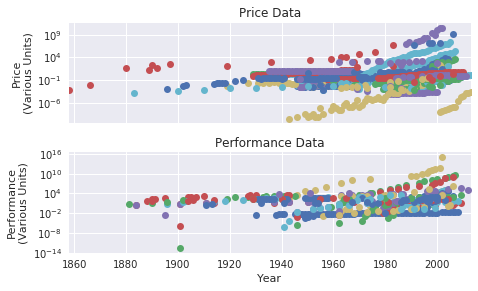

In [10]:
fig = figure(figsize=(fig_width_two_col, fig_width_two_col/golden))
n_rows = 2
n_cols = 1
this_ax = 0

this_ax+=1
ax = fig.add_subplot(n_rows, n_cols, this_ax)
target_tech_names = metadata.ix[metadata['Type']=='Price', 'Name']
empirical_time_series[target_tech_names].plot(marker='o', linewidth=0, legend=False, ax=ax)
yscale('log')
xlabel("Year")
ylabel("Price\n(Various Units)")
ax.set_title("Price Data")
# plot((1975, 1975), ylim(), 'k--')

this_ax+=1
ax = fig.add_subplot(n_rows, n_cols, this_ax, sharex=ax)
target_tech_names = metadata.ix[metadata['Type']=='Performance', 'Name'].values
empirical_time_series[target_tech_names].plot(marker='o',  linewidth=0, legend=False, ax=ax)
yscale('log')
xlabel("Year")
ylabel("Performance\n(Various Units)")
ax.set_title("Performance Data")
# plot((1975, 1975), ylim(), 'k--')

fig.tight_layout()

filename = "Historical_Technology_Data"
fig.savefig(figs_directory+filename+'.png', dpi=440)
fig.savefig(figs_directory+filename+'.pdf')

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


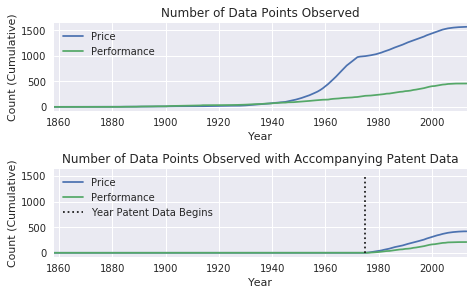

In [190]:
fig = figure(figsize=(fig_width_two_col, fig_width_two_col/golden))
n_cols = 1
n_rows = 2
ax = fig.add_subplot(n_rows,n_cols,1)
for data_type in ['Price', 'Performance']:
    target_tech_names = metadata.ix[metadata['Type']==data_type, 'Name']
    empirical_time_series[target_tech_names].notnull().sum(axis=1).cumsum().plot(label=data_type)
xlabel("Year")
title("Number of Data Points Observed")
ylabel("Count (Cumulative)")
# yscale('log')
legend(loc='upper left')

ax = fig.add_subplot(n_rows,n_cols,2, sharey=ax)
for data_type in ['Price', 'Performance']:
    target_tech_names = metadata.ix[metadata['Type']==data_type, 'Name']
    (patent_time_series[target_tech_names].iloc[:,:,0].notnull() * 
     empirical_time_series[target_tech_names].notnull()).sum(axis=1).cumsum().plot(label=data_type)
plot((1975, 1975), (0,1500), 'k:', label="Year Patent Data Begins")
xlabel("Year")
title("Number of Data Points Observed with Accompanying Patent Data")
ylabel("Count (Cumulative)")
legend(loc='upper left')
# yscale('log')

fig.tight_layout()

filename = "Historical_Technology_Data_Cumulative"
fig.savefig(figs_directory+filename+'.png', dpi=440)
fig.savefig(figs_directory+filename+'.pdf')

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


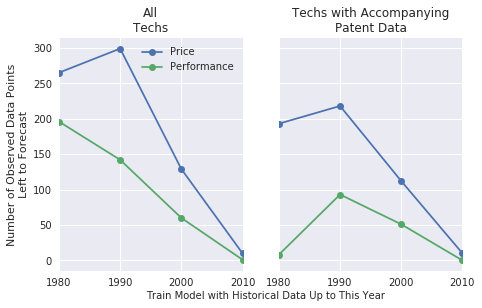

In [187]:
fig = figure(figsize=(fig_width_two_col, fig_width_two_col/golden))
n_cols = 2
min_observeds = [3]
n_rows = len(min_observeds)
this_ax = 0
training_years = [1980, 1990, 2000, 2010]
for min_observed in min_observeds:
    this_ax+=1
    if this_ax>1:
        ax = fig.add_subplot(n_rows,n_cols,this_ax, sharey=ax)
    else:
        ax = fig.add_subplot(n_rows,n_cols,this_ax)
    n_data_points_to_forecast = pd.Series(index=training_years)
    for data_type in ['Price', 'Performance']:
        for training_year in training_years:
            target_tech_names = metadata.ix[metadata['Type']==data_type, 'Name']
            Y = empirical_time_series[target_tech_names]
            time_series_has_data = time_series_with_data_for_training_and_testing(Y, training_year,min_observed=min_observed)
            Y = Y[time_series_has_data]
            n_data_points_to_forecast.loc[training_year] = Y.loc[training_year:].notnull().sum().sum()
        n_data_points_to_forecast.plot(label=data_type,marker='o')
    if this_ax==1:
        ax.set_title('All\nTechs')
        legend()
    
#     xlabel("Train Model with Historical Data Up to This Year")
    if this_ax%2:
        ylabel("Number of Observed Data Points\nLeft to Forecast")
#     if this_ax>2:
#         xlabel("Train Model with Historical Data Up to This Year")
    ax.set_xticks(training_years)

    this_ax +=1
    ax = fig.add_subplot(n_rows,n_cols,this_ax, sharey=ax)
    n_data_points_to_forecast = pd.Series(index=training_years)
    for data_type in ['Price', 'Performance']:
        for training_year in training_years:
            target_tech_names = metadata.ix[metadata['Type']==data_type, 'Name']
            target_tech_names = list(set(target_tech_names.values).intersection(has_patent_data))
            Y = empirical_time_series[target_tech_names].loc[1975:]
            time_series_has_data = time_series_with_data_for_training_and_testing(Y, training_year,min_observed=min_observed)
            Y = Y[time_series_has_data]
            n_data_points_to_forecast.loc[training_year] = Y.loc[training_year:].notnull().sum().sum()
        n_data_points_to_forecast.plot(label=data_type,marker='o')
#     ylabel("Number of Data Points Available to Forecast,"
#            "\nwith Accompanying Patent Data")
    if this_ax==2:
        ax.set_title('Techs with Accompanying\nPatent Data')
    ax.set_xticks(training_years)
#     if this_ax>2:
#         xlabel("Train Model with Historical Data Up to This Year")
# ax = fig.add_subplot(1,1,1)

# fig.suptitle("Number of Observed Data Points Left to Forecast",y=1.02, x=.55)
fig.text(.55,.0, "Train Model with Historical Data Up to This Year",ha='center')

# legend()
fig.tight_layout()

filename = "Observed_Technology_Data_to_Forecast"
fig.savefig(figs_directory+filename+'.png', dpi=440)
fig.savefig(figs_directory+filename+'.pdf')

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


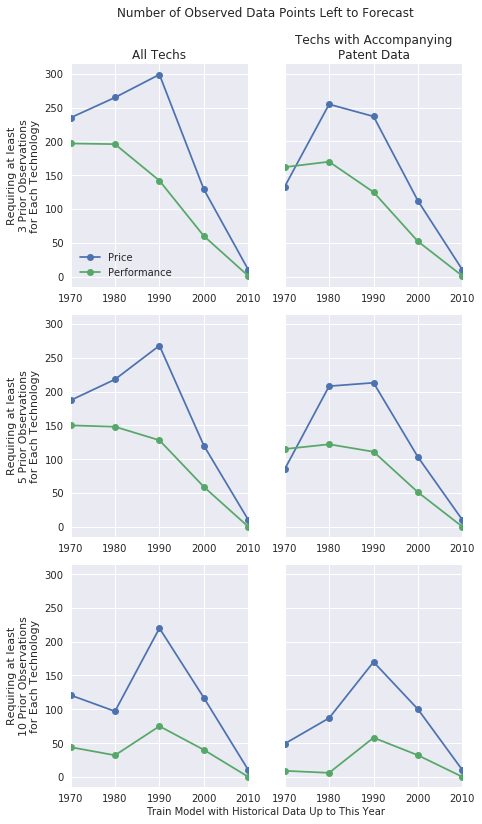

In [77]:
fig = figure(figsize=(fig_width_two_col, fig_width_two_col*golden))
n_cols = 2
min_observeds = [3,5,10]
n_rows = len(min_observeds)
this_ax = 0
training_years = [1970, 1980, 1990, 2000, 2010]
for min_observed in min_observeds:
    this_ax+=1
    if this_ax>1:
        ax = fig.add_subplot(n_rows,n_cols,this_ax, sharey=ax)
    else:
        ax = fig.add_subplot(n_rows,n_cols,this_ax)
    n_data_points_to_forecast = pd.Series(index=training_years)
    for data_type in ['Price', 'Performance']:
        for training_year in training_years:
            target_tech_names = metadata.ix[metadata['Type']==data_type, 'Name']
            Y = empirical_time_series[target_tech_names]
            time_series_has_data = time_series_with_data_for_training_and_testing(Y, training_year,min_observed=min_observed)
            Y = Y[time_series_has_data]
            n_data_points_to_forecast.loc[training_year] = Y.loc[training_year:].notnull().sum().sum()
        n_data_points_to_forecast.plot(label=data_type,marker='o')
    if this_ax==1:
        ax.set_title('All Techs')
        legend()
    
#     xlabel("Train Model with Historical Data Up to This Year")
    if this_ax%2:
        ylabel("Requiring at least\n%i Prior Observations\nfor Each Technology"%min_observed)
#     if this_ax>2:
#         xlabel("Train Model with Historical Data Up to This Year")

    this_ax +=1
    ax = fig.add_subplot(n_rows,n_cols,this_ax, sharey=ax)
    n_data_points_to_forecast = pd.Series(index=training_years)
    for data_type in ['Price', 'Performance']:
        for training_year in training_years:
            target_tech_names = metadata.ix[metadata['Type']==data_type, 'Name']
            target_tech_names = list(set(target_tech_names.values).intersection(has_patent_data))
            Y = empirical_time_series[target_tech_names]
            time_series_has_data = time_series_with_data_for_training_and_testing(Y, training_year,min_observed=min_observed)
            Y = Y[time_series_has_data]
            n_data_points_to_forecast.loc[training_year] = Y.loc[training_year:].notnull().sum().sum()
        n_data_points_to_forecast.plot(label=data_type,marker='o')
#     ylabel("Number of Data Points Available to Forecast,"
#            "\nwith Accompanying Patent Data")
    if this_ax==2:
        ax.set_title('Techs with Accompanying\nPatent Data')
#     if this_ax>2:
#         xlabel("Train Model with Historical Data Up to This Year")
# ax = fig.add_subplot(1,1,1)

fig.suptitle("Number of Observed Data Points Left to Forecast",y=1.02, x=.55)
fig.text(.55,.0, "Train Model with Historical Data Up to This Year",ha='center')

# legend()
fig.tight_layout()

# filename = "Observed_Technology_Data_to_Forecast"
# fig.savefig(figs_directory+filename+'.png', dpi=440)
# fig.savefig(figs_directory+filename+'.pdf')

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


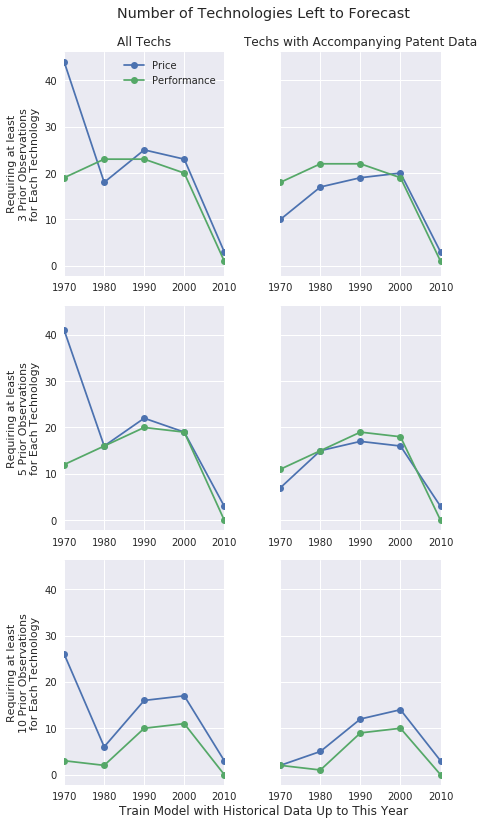

In [13]:
fig = figure(figsize=(fig_width_two_col, fig_width_two_col*golden))
n_cols = 2
min_observeds = [3,5,10]
n_rows = len(min_observeds)
this_ax = 0
training_years = [1970, 1980, 1990, 2000, 2010]
for min_observed in min_observeds:
    this_ax+=1
    if this_ax>1:
        ax = fig.add_subplot(n_rows,n_cols,this_ax, sharey=ax)
    else:
        ax = fig.add_subplot(n_rows,n_cols,this_ax)
    n_data_points_to_forecast = pd.Series(index=training_years)
    for data_type in ['Price', 'Performance']:
        for training_year in training_years:
            target_tech_names = metadata.ix[metadata['Type']==data_type, 'Name']
            Y = empirical_time_series[target_tech_names]
            time_series_has_data = time_series_with_data_for_training_and_testing(Y, training_year,min_observed=min_observed)
            Y = Y[time_series_has_data]
            n_data_points_to_forecast.loc[training_year] = Y.loc[training_year:].notnull().any().sum()
        n_data_points_to_forecast.plot(label=data_type,marker='o')
    if this_ax==1:
        ax.set_title('All Techs')
        legend()
    
#     xlabel("Train Model with Historical Data Up to This Year")
    if this_ax%2:
        ylabel("Requiring at least\n%i Prior Observations\nfor Each Technology"%min_observed)
#     if this_ax>2:
#         xlabel("Train Model with Historical Data Up to This Year")

    this_ax +=1
    ax = fig.add_subplot(n_rows,n_cols,this_ax, sharey=ax)
    n_data_points_to_forecast = pd.Series(index=training_years)
    for data_type in ['Price', 'Performance']:
        for training_year in training_years:
            target_tech_names = metadata.ix[metadata['Type']==data_type, 'Name']
            target_tech_names = list(set(target_tech_names.values).intersection(has_patent_data))
            Y = empirical_time_series[target_tech_names]
            time_series_has_data = time_series_with_data_for_training_and_testing(Y, training_year,min_observed=min_observed)
            Y = Y[time_series_has_data]
            n_data_points_to_forecast.loc[training_year] = Y.loc[training_year:].notnull().any().sum()
        n_data_points_to_forecast.plot(label=data_type,marker='o')
#     ylabel("Number of Data Points Available to Forecast,"
#            "\nwith Accompanying Patent Data")
    if this_ax==2:
        ax.set_title('Techs with Accompanying Patent Data')
#     if this_ax>2:
#         xlabel("Train Model with Historical Data Up to This Year")
# ax = fig.add_subplot(1,1,1)

fig.suptitle("Number of Technologies Left to Forecast",y=1.02, x=.55)
fig.text(.55,.0, "Train Model with Historical Data Up to This Year",ha='center')

# legend()
fig.tight_layout()

filename = "Observed_Technologies_to_Forecast"
fig.savefig(figs_directory+filename+'.png', dpi=440)
fig.savefig(figs_directory+filename+'.pdf')

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__ma

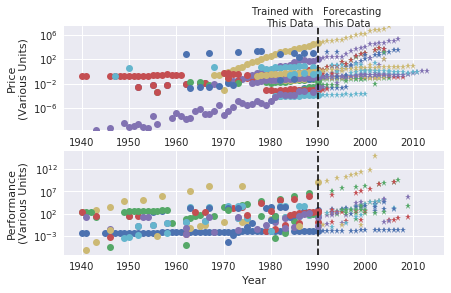

In [199]:
training_year = 1990
data_start_year = 1940

fig = figure(figsize=(fig_width_two_col, fig_width_two_col/golden))
ax = fig.add_subplot(2,1,1)
data_type = 'Price'
target_tech_names = metadata.ix[metadata['Type']==data_type, 'Name']
Y = empirical_time_series[target_tech_names].loc[data_start_year:]
time_series_has_data = time_series_with_data_for_training_and_testing(Y, training_year)
Y = Y[time_series_has_data]
Y = pd.Panel({data_type:Y}).transpose([2,1,0])
Y_training = Y.copy()
Y_testing = Y.copy()
Y_training.loc[:,training_year+1:] = nan
Y_testing.loc[:, :training_year] = nan

for c in Y_training.items:
    line = ax.plot(Y_training[c], marker='o', linewidth=0)
    ax.plot(Y_testing[c], marker='*', color=line[0].get_color(), linewidth=0)
lims = ylim()
ax.plot((training_year,training_year), lims, 'k--', label='Training Year')
ax.text(training_year-1, lims[1]+1, "Trained with\nThis Data", horizontalalignment='right')
ax.text(training_year+1, lims[1]+1, "Forecasting\nThis Data", horizontalalignment='left')
yscale('log')
ylim(lims)
xlabel("Year")
ylabel("%s\n(Various Units)"%data_type)

ax = fig.add_subplot(2,1,2,sharex=ax)
data_type = 'Performance'
target_tech_names = metadata.ix[metadata['Type']==data_type, 'Name']
Y = empirical_time_series[target_tech_names].loc[data_start_year:]
time_series_has_data = time_series_with_data_for_training_and_testing(Y, training_year)
Y = Y[time_series_has_data]
Y = pd.Panel({data_type:Y}).transpose([2,1,0])
Y_training = Y.copy()
Y_testing = Y.copy()
Y_training.loc[:,training_year+1:] = nan
Y_testing.loc[:, :training_year] = nan

for c in Y_training.items:
    line = ax.plot(Y_training[c], marker='o', linewidth=0)
    ax.plot(Y_testing[c], marker='*', color=line[0].get_color(), linewidth=0)
yscale('log')
lims = ylim()
ax.plot((training_year,training_year), lims, 'k--', label='Training Year')
# ax.text(training_year-1, lims[1]+1, "Trained with\nThis Data", horizontalalignment='right')
# ax.text(training_year+1, lims[1]+1, "Forecasting\nThis Data", horizontalalignment='left')
ylim(lims)
xlabel("Year")
ylabel("%s\n(Various Units)"%data_type)


filename = "Data_to_Forecast"
fig.savefig(figs_directory+filename+'.png', dpi=440)
fig.savefig(figs_directory+filename+'.pdf', bbox_inches='tight')

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


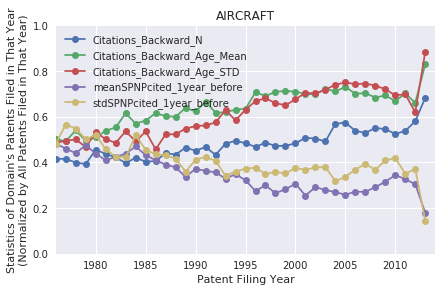

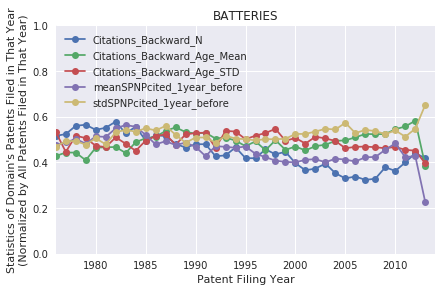

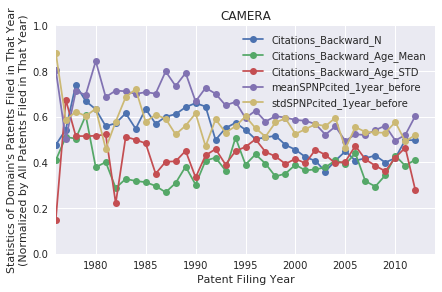

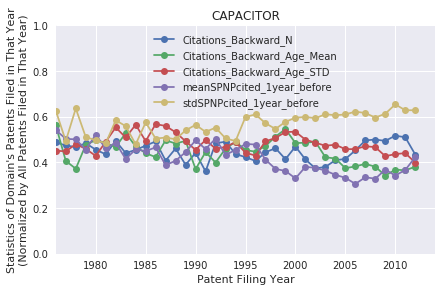

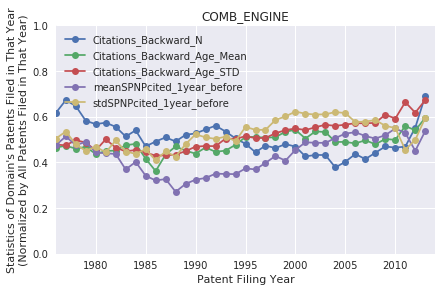

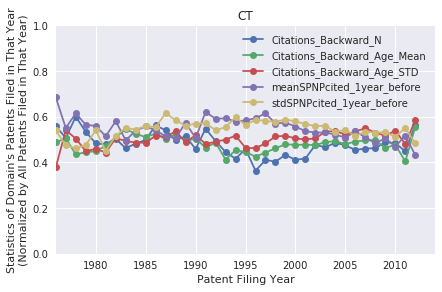

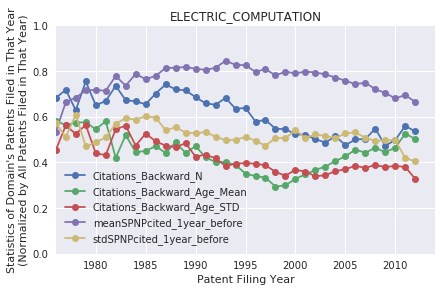

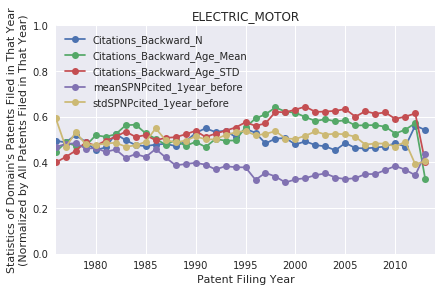

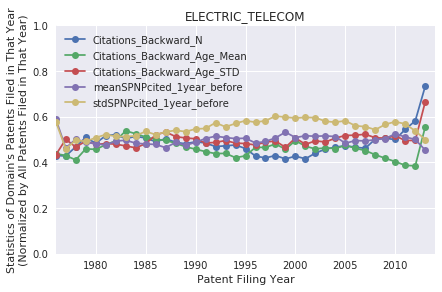

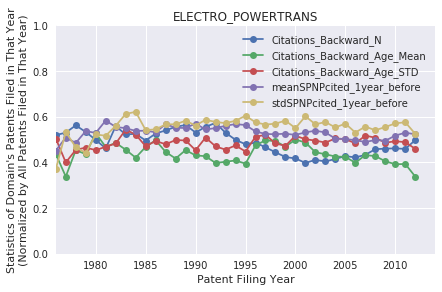

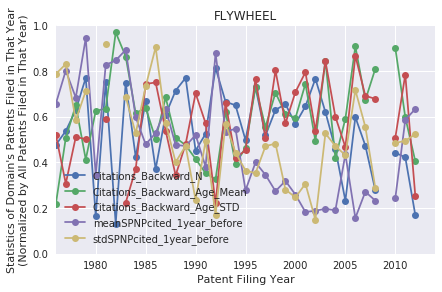

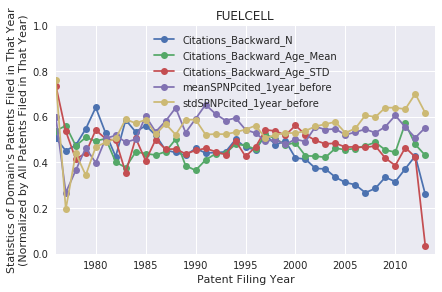

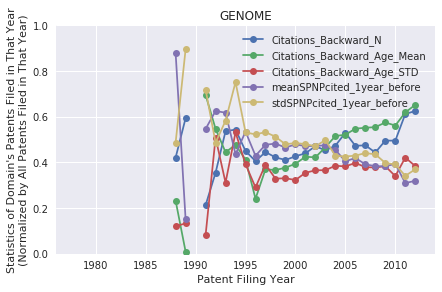

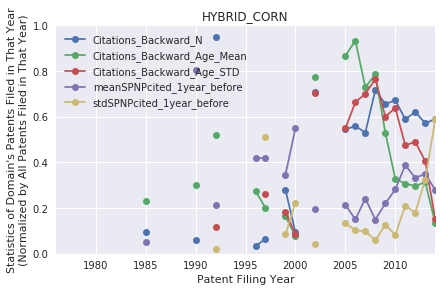

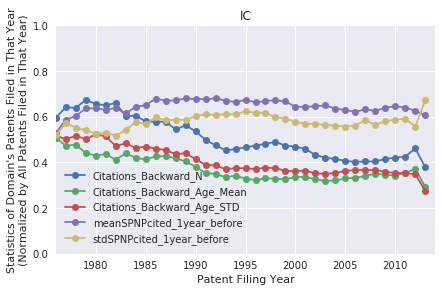

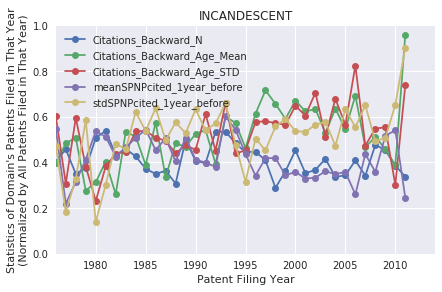

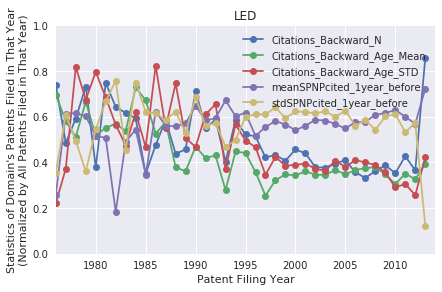

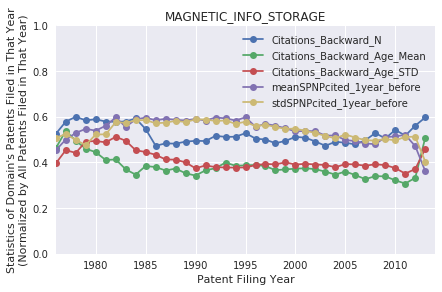

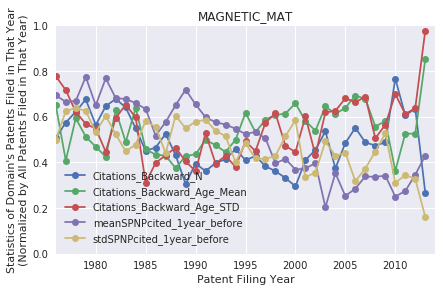

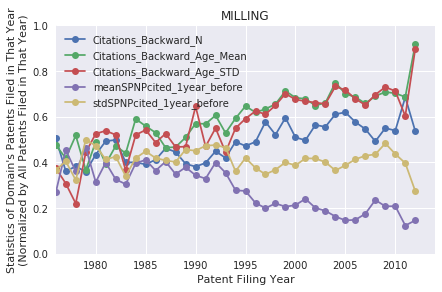

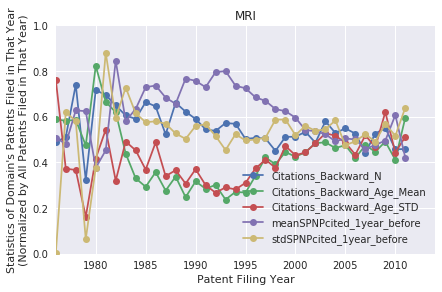

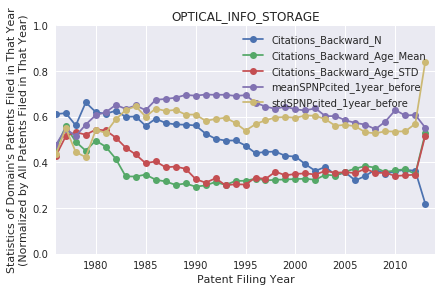

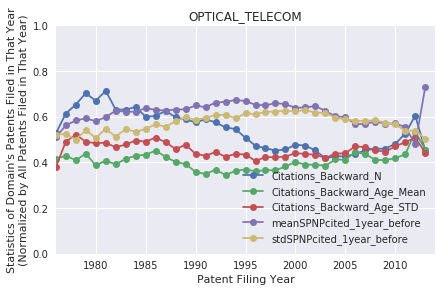

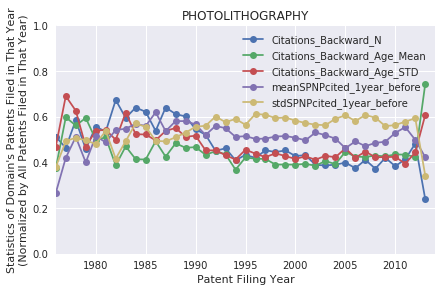

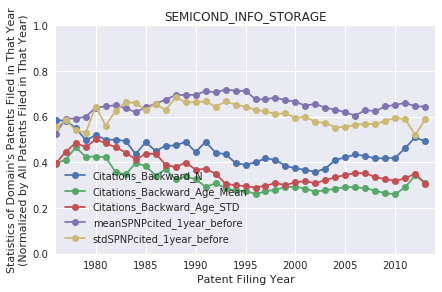

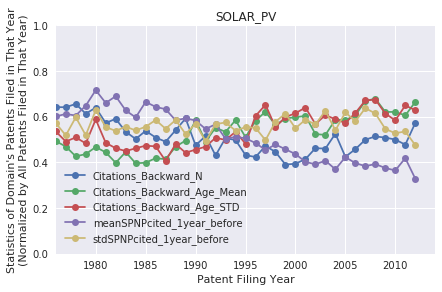

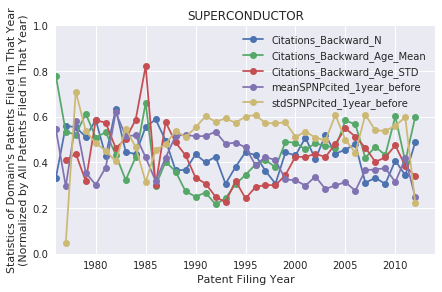

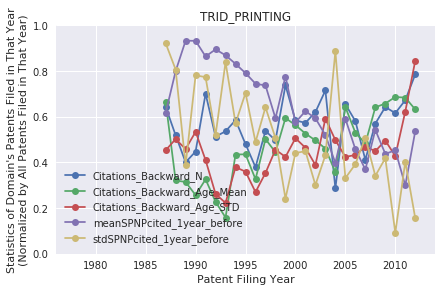

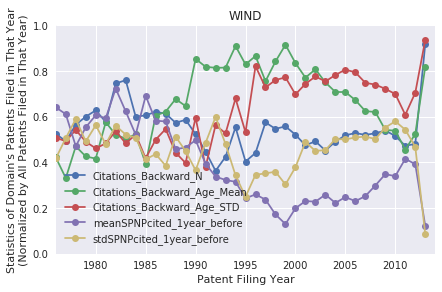

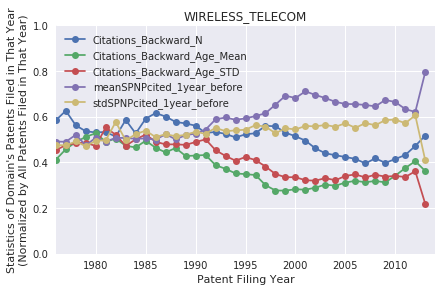

In [847]:
from matplotlib.backends.backend_pdf import PdfPages
plots = PdfPages('/home/jeffrey_alstott/Dropbox/Apps/ShareLaTeX/Forecasting_Technologies/figs/patent_data_plots.pdf')

for domain in unique(predictors_by_domain.index.get_level_values(level=0)):
    fig = figure(figsize=(fig_width_two_col,fig_width_two_col/golden))
    ax = fig.add_subplot(1,1,1)
    predictors_by_domain.loc[domain].drop('N_Patents', axis=1).plot(marker='o', ax=ax)
    ylim(0,1)
    title(domain)
    xlabel("Patent Filing Year")
    ylabel("Statistics of Domain's Patents Filed in That Year\n(Normalized by All Patents Filed in That Year)")
    
    plots.savefig(fig, bbox_inches='tight')
    
#     filename = "Patent_Data_%s"%domain
#     fig.savefig(figs_directory+filename+'.png', dpi=440)
#     fig.savefig(figs_directory+filename+'.pdf', bbox_inches='tight')
plots.close()

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


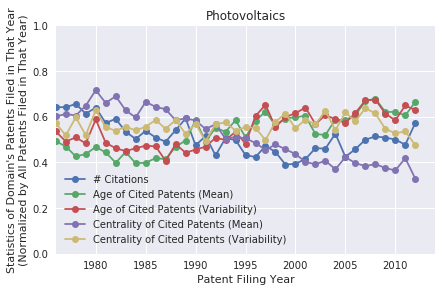

In [296]:
### Just change the title to something smarter for SOLAR_PV, to use an example.
predictor_renaming = {'Citations_Backward_N': '# Citations',
                     'Citations_Backward_Age_Mean': 'Age of Cited Patents (Mean)',
                     'Citations_Backward_Age_STD': 'Age of Cited Patents (Variability)',
                     'meanSPNPcited_1year_before': 'Centrality of Cited Patents (Mean)',
                     'stdSPNPcited_1year_before': 'Centrality of Cited Patents (Variability)'}
for domain in ['SOLAR_PV']:
    fig = figure(figsize=(fig_width_two_col,fig_width_two_col/golden))
    predictors_by_domain.loc[domain].drop('N_Patents', axis=1).rename(columns=predictor_renaming).plot(marker='o')
    ylim(0,1)
    title('Photovoltaics')
    xlabel("Patent Filing Year")
    ylabel("Statistics of Domain's Patents Filed in That Year\n(Normalized by All Patents Filed in That Year)")

    filename = "Patent_Data_%s"%domain
    savefig(figs_directory+filename+'.png', dpi=440)
    savefig(figs_directory+filename+'.pdf', bbox_inches='tight')

Build Predictive Models
===

In [766]:
target_tech_names = metadata.ix[metadata['Type']==data_type, 'Name']
Y = empirical_time_series[target_tech_names]
# ind = Y.count()>10
# ind = ind[ind].index.values
# Y = Y[ind]

# ind = Y.loc[1990:].count()>1
# ind = ind[ind].index.values
# Y = Y[ind]

# ind = Y.loc[:1970].count()>1
# ind = ind[ind].index.values
# Y = Y[ind]

Fitting took 0.05 minutes
"Maximum Rhat of 1.01"
"0 of 1000 iterations saturated the maximum tree depth of 15 (0.0%)"
"Chain 0: E-BFMI = 0.685348347870362"
"Chain 1: E-BFMI = 0.8049888104423029"
"Chain 2: E-BFMI = 0.5914261422112855"
"Chain 3: E-BFMI = 0.7167645379587907"
"No divergences"


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


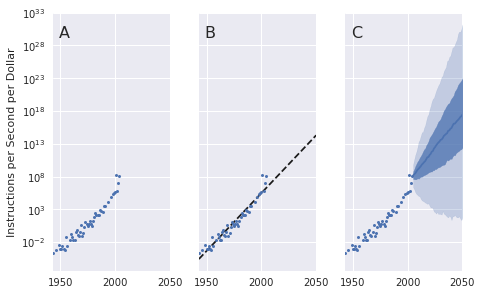

In [393]:
col = 'electronic_computation_mips_per_$'
horizon = 2050 

d = Y[col].copy()*10**6
d = d.reindex(arange(d.first_valid_index(), horizon+1))

model = TimeSeriesModel(Y=log(d.values), difference=[1])
start_time = time()
max_depth = 15
model.sampling(n_jobs=n_jobs, iter=n_iterations, control={'max_treedepth':max_depth})
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))
test_model_fit(model.fit, ['mu', 'sigma'], max_depth=max_depth)


fig = figure(figsize=(fig_width_two_col, fig_width_two_col/golden))

ax = fig.add_subplot(1,3,1)
d.dropna().plot(marker='o', linewidth=0, markersize=3)
xticks([1950,2000,2050])
yscale('log')
ylabel("Instructions per Second per Dollar")
label='A'
ax.text(0.05, 0.95, label, transform=ax.transAxes,
      fontsize=16, va='top')

ax = fig.add_subplot(1,3,2, sharey=ax)#, sharex=ax)
y = d.dropna().values
x = d.dropna().index.values
from scipy.stats import linregress
fit = linregress(x,log(y))
plot([min(x),horizon],exp(fit.intercept+fit.slope*array([min(x),horizon])), 'k--')
d.dropna().plot(marker='o', linewidth=0, markersize=3)
yscale('log')
xticks([1950,2000,2050])
label='B'
ax.text(0.05, 0.95, label, transform=ax.transAxes,
      fontsize=16, va='top')

ax = fig.add_subplot(1,3,3, sharey=ax)#, sharex=ax)
d.dropna().plot(marker='o', linewidth=0, markersize=3)
ind = where(d.index==d.last_valid_index()+1)[0][0]
plot_time_series_inference(exp(model.fit['Y_latent'][:,:,ind:]),x=d.index[ind:], color='b')
yscale('log')
xticks([1950,2000,2050])
label='C'
ax.text(0.05, 0.95, label, transform=ax.transAxes,
      fontsize=16, va='top')

fig.tight_layout()

filename = "trend_extrapolation_example"
fig.savefig(figs_directory+filename+'.png', dpi=440)
fig.savefig(figs_directory+filename+'.pdf', bbox_inches='tight')

In [398]:
print(exp(fit.intercept+fit.slope*2030)*1000)

ind = where(d.index==2030)[0][0]
from scipy.stats import scoreatpercentile
scoreatpercentile(exp(model.fit['Y_latent'][:,:,ind]), [2.5, 25,75, 97.5])*1000

5.79468482134e+13


array([  1.87021350e+05,   3.67326033e+12,   6.05489107e+19,
         4.68000261e+25])

Fitting took 0.02 minutes
"Maximum Rhat of 1.02"
"0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)"
"Chain 0: E-BFMI = 0.9478929782612424"
"Chain 1: E-BFMI = 0.642221895106004"
"Chain 2: E-BFMI = 0.7193476104591142"
"Chain 3: E-BFMI = 0.7754157405224905"
"No divergences"


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


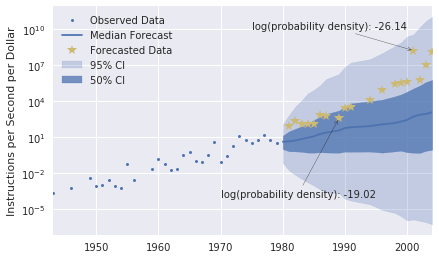

In [798]:
col = 'electronic_computation_mips_per_$'
training_year = 1980

d = Y[col].copy().dropna()*10**6
d_training = d.copy()
d_training.loc[training_year:] = nan
d_testing = d.copy()
d_testing.loc[:training_year] = nan
model = TimeSeriesModel(Y=log(d_training.values), difference=[1])
start_time = time()
model.sampling(n_jobs=n_jobs, iter=n_iterations)
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))
test_model_fit(model.fit, ['mu', 'sigma'])


fig = figure(figsize=(fig_width_two_col, fig_width_two_col/golden))

d_training.plot(marker='o', linewidth=0, markersize=3,
               label='Observed Data')
ind = where(d.index==1980)[0][0]
plot_time_series_inference(exp(model.fit['Y_latent'][:,:,ind:]),x=d.index[ind:], color='b', labels=True)
d_testing.plot(marker='*', linewidth=0, markersize=10,color='y', 
              label='Forecasted Data')

d_forecast_quality = test_prediction(exp(model.fit['Y_latent'].transpose([1,2,3,0])), 
                                     expand_dims(expand_dims(d_testing,0),-1))
d_forecast_quality['T'].replace(arange(len(d_testing.index)), 
                                d_testing.index,inplace=True)
d_forecast_quality.set_index('T', inplace=True)

lpd_max = 1989#d_forecast_quality['lpdf'].argmax()
lpd_min = 2001#d_forecast_quality['lpdf'].argmin()

annotate(s='log(probability density): %.2f'%d_forecast_quality.loc[lpd_max,'lpdf'],
        xy=(lpd_max, d[lpd_max]),
        xytext=(1970,10**-4),
        arrowprops={'arrowstyle': '->'})

annotate(s='log(probability density): %.2f'%d_forecast_quality.loc[lpd_min,'lpdf'],
        xy=(lpd_min, d[lpd_min]),
        xytext=(1975, 10**10),
        arrowprops={'arrowstyle': '->'})

legend()
# xticks([1950,2000,2050])
yscale('log')
ylabel("Instructions per Second per Dollar")

filename = "forecast_evaluation"
fig.savefig(figs_directory+filename+'.png', dpi=440) 
fig.savefig(figs_directory+filename+'.pdf', bbox_inches='tight')

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/mpl_toolkits/mplot3d/axes3d.py:2480: UserWarning: x, y, and z must be the same length.
  warnings.warn('x, y, and z must be the same length.')
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


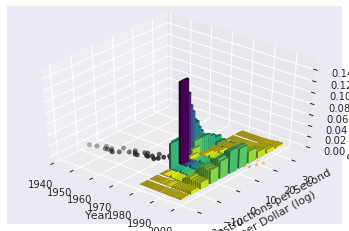

In [762]:
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ys = arange(-20,40,5)
# for t in arange(20):
#     zs, ys = histogram((model.fit['Y_latent'])[:,0,t+ind,0],normed=True, bins=ys)
#     ax.bar3d(ones(len(ys)-1)*(t+1980), ys, zeros(len(ys)-1), 1*ones(len(ys)-1), 4*ones(len(ys)-1), zs, 
#              color=get_cmap('viridis_r')(zs/.14))#((zs-zs.min())/zs.max()), alpha=1)
# ax.scatter(d_training.index, log(d_training.values),c='k')
# ax.scatter(d_testing.index, log(d_testing.values),c='y', marker='*')

# xlabel("Year")
# ylabel("Instructions per Second\nper Dollar (log)")
# ax.set_zlabel("Probability\Density")
# ax.view_init(40, -50)

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


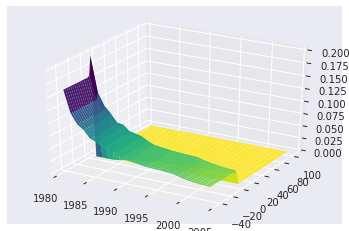

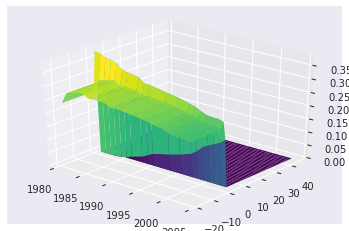

In [761]:
# xs = d_testing.dropna().index.values
# ys = logspace(-20, 45)
# X, Y = meshgrid(xs, ys)
# Z = zeros((len(xs), len(ys)))
# Z_c = zeros((len(xs), len(ys)))
# for t in arange(len(xs)):
#     q = gaussian_kde((model.fit['Y_latent'])[:,0,t+ind,0])
#     for y in arange(len(ys)):
#         Z[t,y] = q.pdf(ys[y])
#         Z_c[t,y] = q.integrate_box_1d(-inf, ys[y])
        
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# from matplotlib.colors import LogNorm
# # Plot the surface.
# surf = ax.plot_surface(X, log(Y), Z.T, cmap='viridis_r', 
#                        linewidth=0, #antialiased=False,
#                       )

# ax.view_init(30, -60)


# fig = plt.figure()
# ax = fig.gca(projection='3d')
# from matplotlib.colors import LogNorm
# # Plot the surface.
# surf = ax.plot_surface(X, log10(Y), (.5-abs(Z_c.T-.5)), cmap='viridis', 
#                        linewidth=0, #antialiased=False,
#                       )

# ax.view_init(30, -50)

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


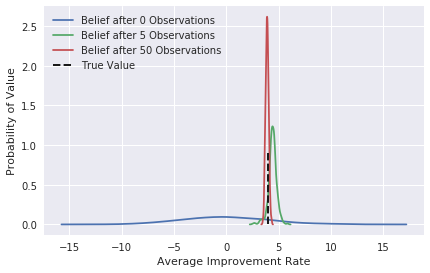

In [413]:
### Show priors and how they update to posteriors

n = 1
t = 10000
sigma = 1
mu = 4

Y = (randn(t,n)*sigma)+mu

fig = figure(figsize=(fig_width_two_col,fig_width_two_col/golden))
model_priors = TimeSeriesModel(Y=Y, return_priors=True)
model_priors.sampling(n_jobs=n_jobs, iter=n_iterations)
sns.kdeplot(model_priors.fit['mu'][:,0,0], label='Belief after 0 Observations')

n_observations = 5
model_priors = TimeSeriesModel(Y=Y[:n_observations])
model_priors.sampling(n_jobs=n_jobs, iter=n_iterations)
sns.kdeplot(model_priors.fit['mu'][:,0,0], label='Belief after {:,} Observations'.format(n_observations))

n_observations = 50
model_priors = TimeSeriesModel(Y=Y[:n_observations])
model_priors.sampling(n_jobs=n_jobs, iter=n_iterations)
sns.kdeplot(model_priors.fit['mu'][:,0,0], label='Belief after {:,} Observations'.format(n_observations))

# n_observations = 50
# model_priors = TimeSeriesModel(Y=Y[:n_observations])
# model_priors.sampling(n_jobs=n_jobs, iter=n_iterations)
# sns.kdeplot(model_priors.fit['mu'][:,0,0], label='Belief after {:,} Observations'.format(n_observations))

# yscale('log')
plot((mu,mu), (0,ylim()[1]*.33), 'k--', label='True Value', linewidth=2)
legend(loc='upper left')
xlabel("Average Improvement Rate")
ylabel("Probability of Value")

filename = "bayesian_updating"
fig.savefig(figs_directory+filename+'.png', dpi=440)
fig.savefig(figs_directory+filename+'.pdf', bbox_inches='tight')

In [297]:
training_year = 1990
data_start_year = 1940
data_type = 'Price'

target_tech_names = metadata.ix[metadata['Type']==data_type, 'Name']
Y = log(empirical_time_series[target_tech_names]).loc[data_start_year:]
time_series_has_data = time_series_with_data_for_training_and_testing(Y, training_year)
Y = Y[time_series_has_data]
Y = pd.Panel({data_type:Y}).transpose([2,1,0])
Y_training = Y.copy()
Y_testing = Y.copy()
Y_training.loc[:,training_year+1:] = nan
Y_testing.loc[:, :training_year] = nan

# Y_testing = Y_testing[time_series_has_data[:10]]
# Y_training = Y_training[time_series_has_data[:10]]

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


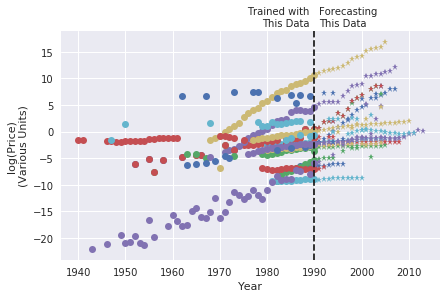

In [182]:
fig = figure(figsize=(fig_width_two_col, fig_width_two_col/golden))
ax = fig.add_subplot(1,1,1)
# Y_training.plot(marker='o',legend=False, ax=ax)
# Y_testing.plot(marker='*',legend=False, ax=ax)
for c in Y_training.items:
    line = ax.plot(Y_training[c], marker='o', linewidth=0)
    ax.plot(Y_testing[c], marker='*', color=line[0].get_color(), linewidth=0)
# lines = ax.plot(Y_training,marker='o')
# ax.plot(Y_testing,marker='*', color=array([array(l.get_color()) for l in lines]))
lims = ylim()
ax.plot((training_year,training_year), lims, 'k--', label='Training Year')
ax.text(training_year-1, lims[1]+1, "Trained with\nThis Data", horizontalalignment='right')
ax.text(training_year+1, lims[1]+1, "Forecasting\nThis Data", horizontalalignment='left')
ylim(lims)
# legend()
xlabel("Year")
ylabel("log(%s)\n(Various Units)"%data_type)

filename = "Data_to_Forecast_%s"%data_type
fig.savefig(figs_directory+filename+'.png', dpi=440)
fig.savefig(figs_directory+filename+'.pdf', bbox_inches='tight')

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


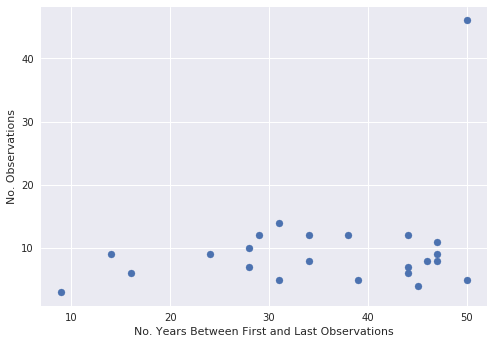

In [695]:
scatter([Y_training[k].last_valid_index()-Y_training[k].first_valid_index() for k in Y_training.items],
        Y_training.notnull().sum(axis=1).values)
xlabel("No. Years Between First and Last Observations")
ylabel("No. Observations")

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplo

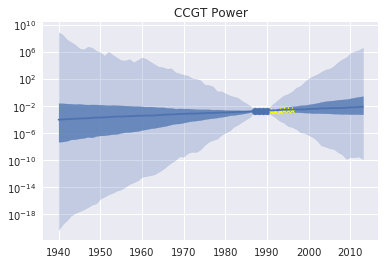

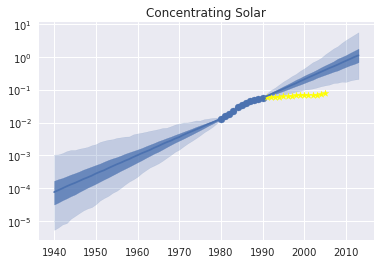

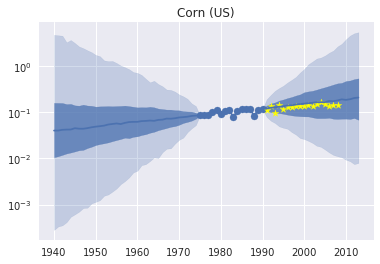

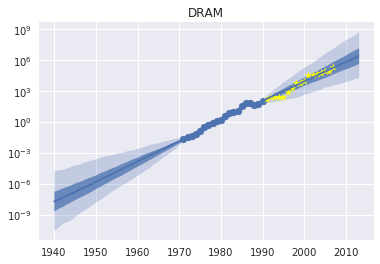

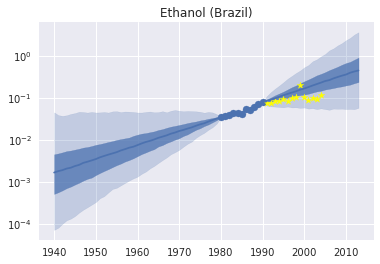

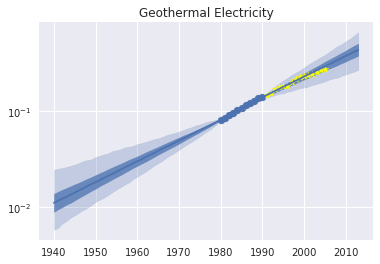

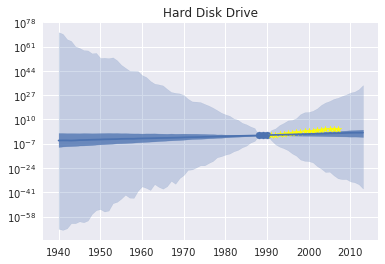

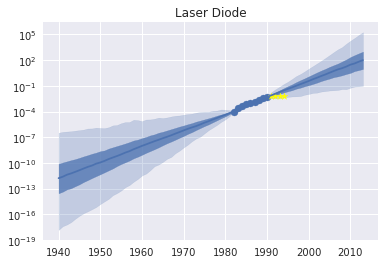

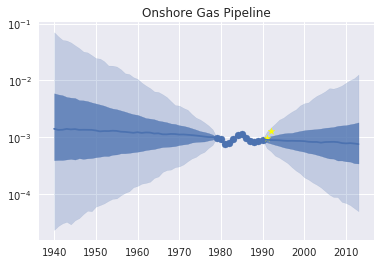

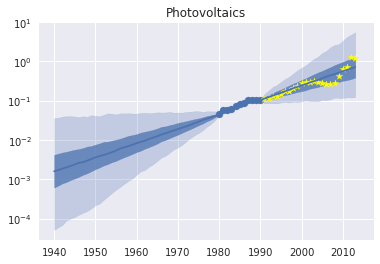

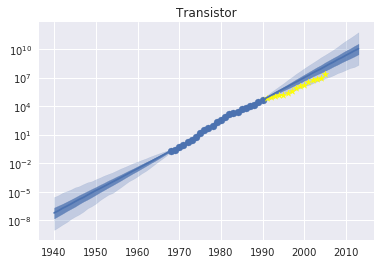

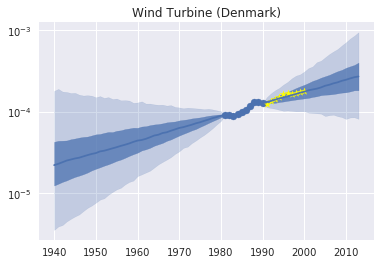

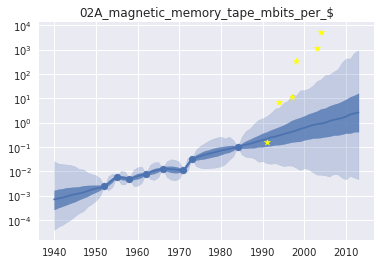

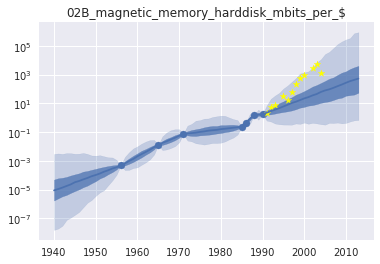

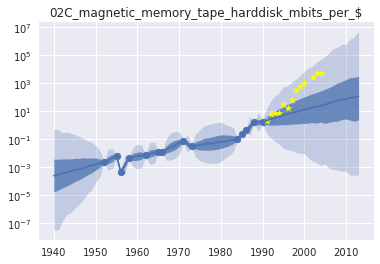

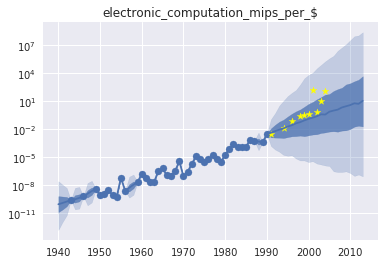

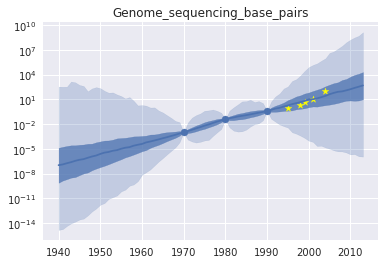

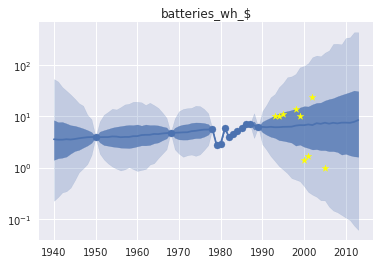

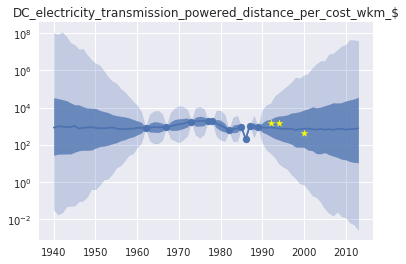

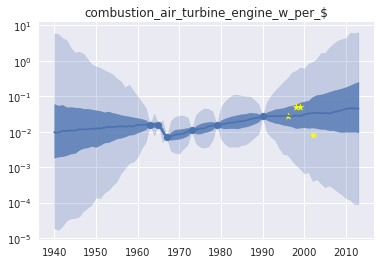

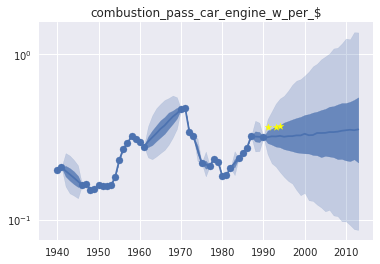

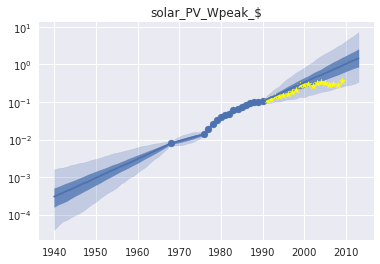

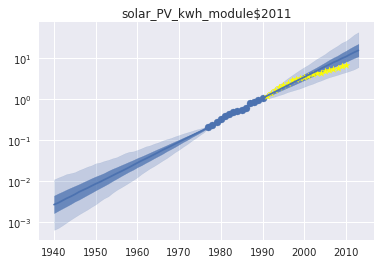

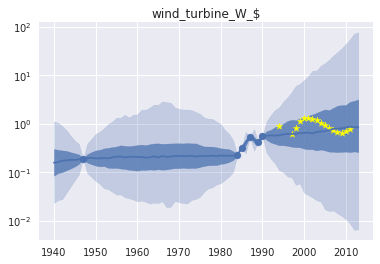

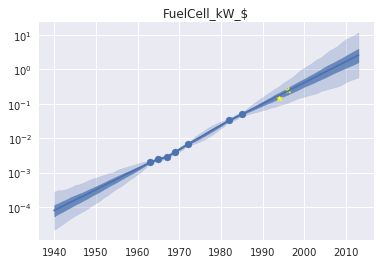

In [148]:
data_type = 'Price'
models_to_plot = pickle.load(open('separate_models_forecasts_%s'%data_type, 'rb'))
model_type = 'ARIMA(0,0)'

for i in arange(models_to_plot[model_type].shape[1]):
    figure()
    plot_time_series_inference(exp(models_to_plot[model_type]), ind=i,D=-1, x=models_to_plot['training'].major_axis)
    scatter(models_to_plot['training'].major_axis,exp(models_to_plot['training']).iloc[i,:,-1])#, s=1)
    scatter(models_to_plot['training'].major_axis,exp(models_to_plot['testing']).iloc[i,:,-1], marker='*', c='yellow')#, s=4)
    title(models_to_plot['training'].items[i])
    yscale('log')

278 predictions
Portion in 95% Confidence Interval: 0.94
Portion in 50% Confidence Interval: 0.55


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:51: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

/home/jeffrey_alstott/anaconda3/lib/python3.5/

130 predictions
Portion in 95% Confidence Interval: 0.35
Portion in 50% Confidence Interval: 0.12


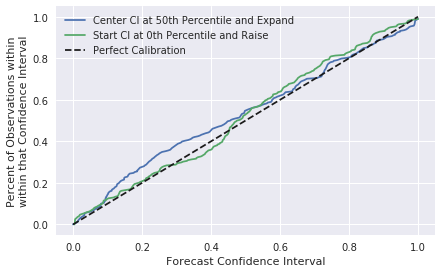

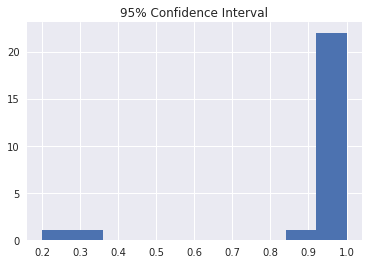

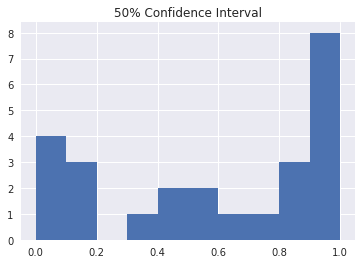

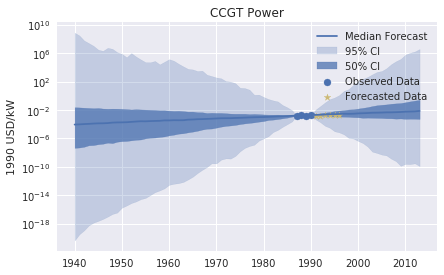

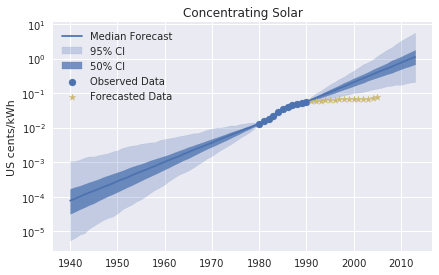

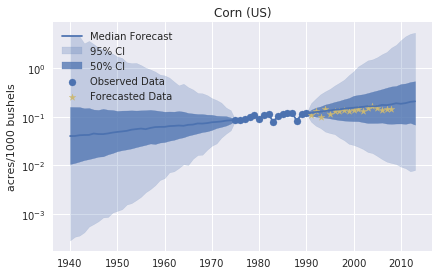

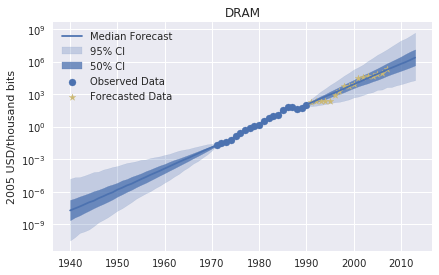

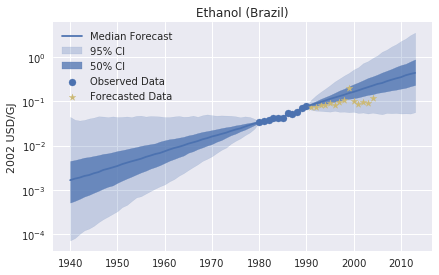

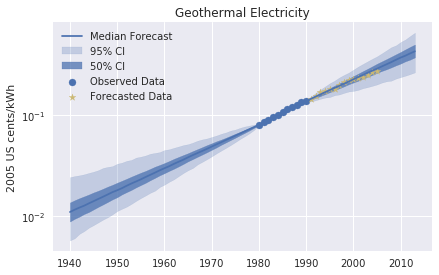

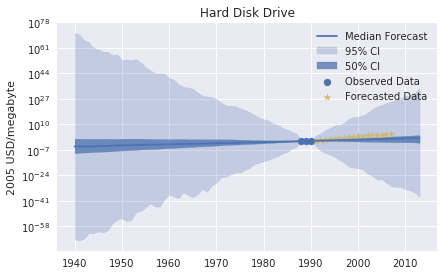

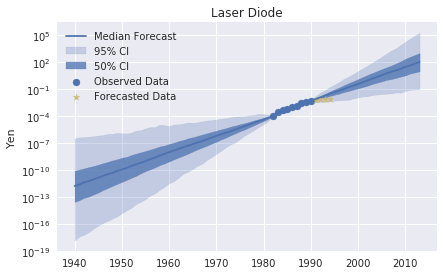

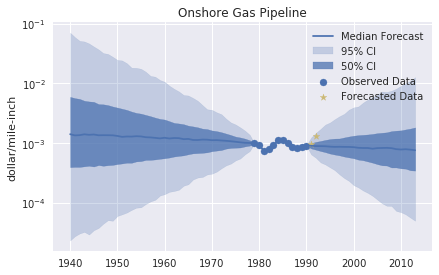

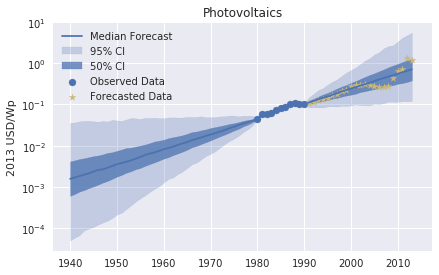

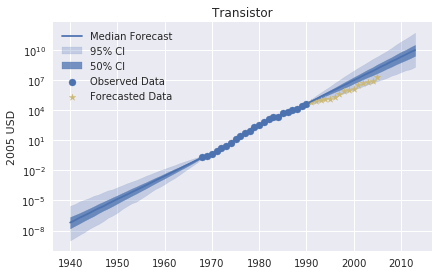

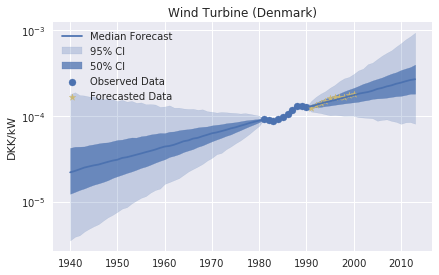

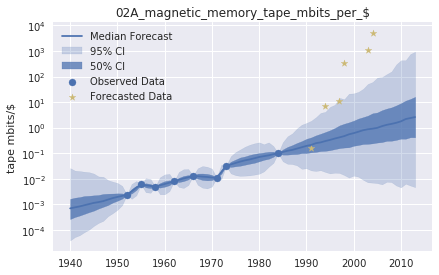

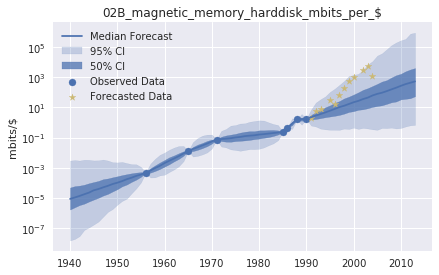

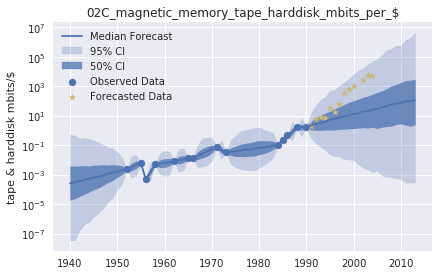

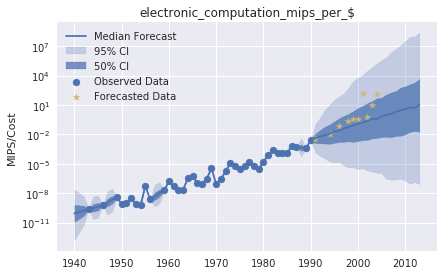

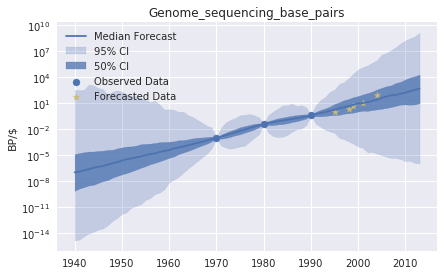

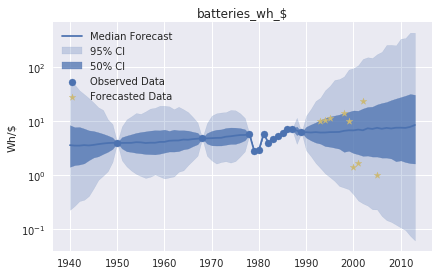

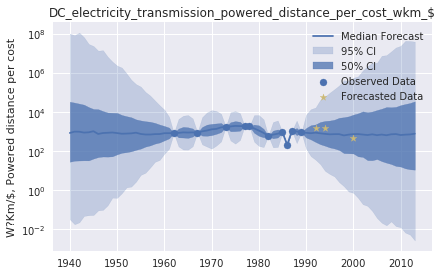

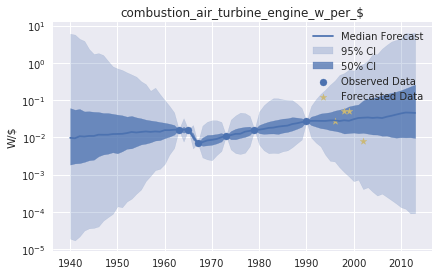

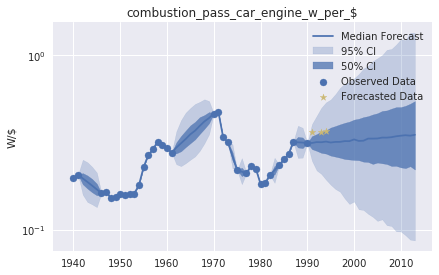

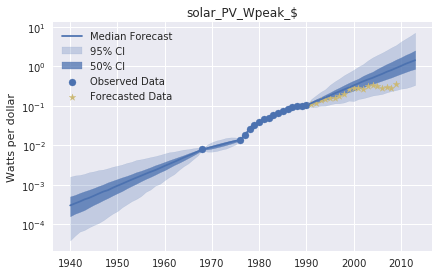

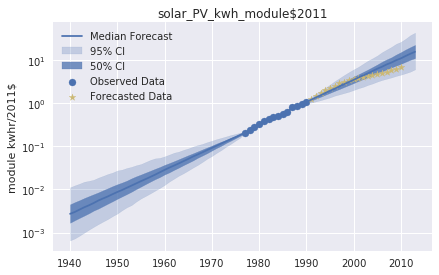

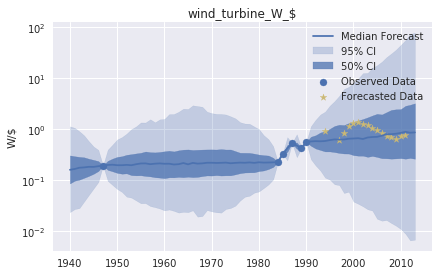

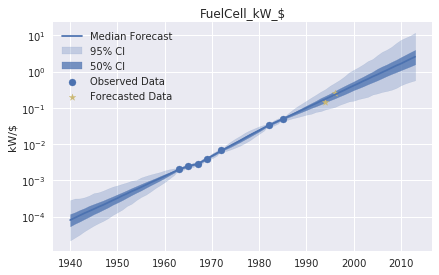

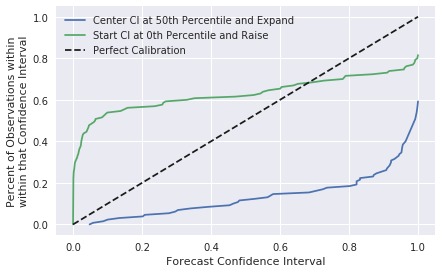

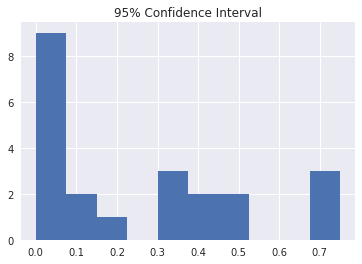

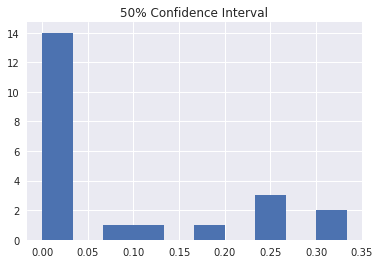

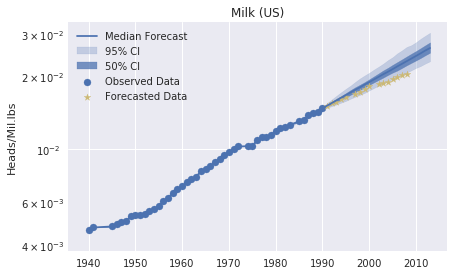

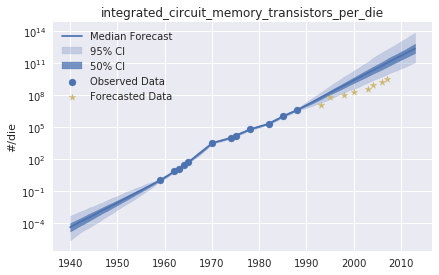

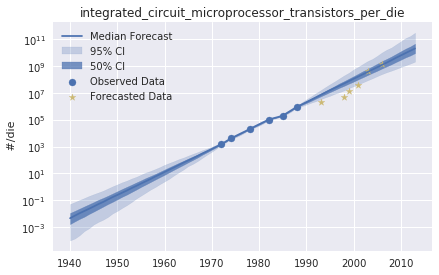

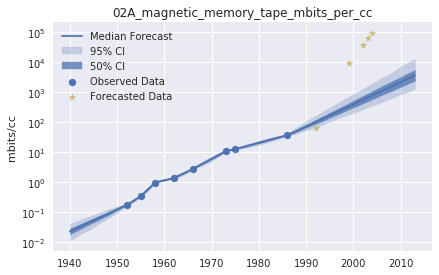

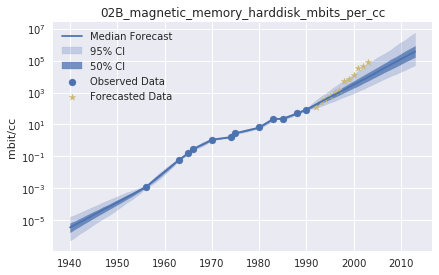

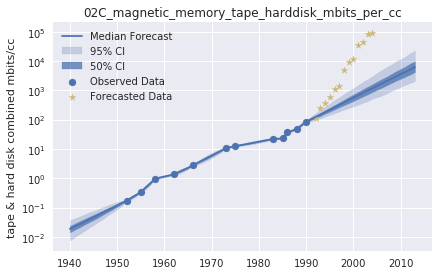

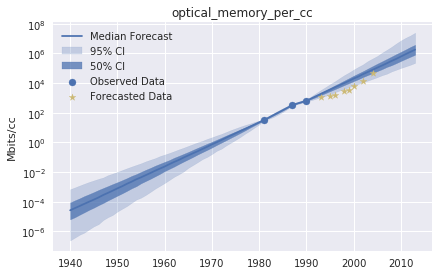

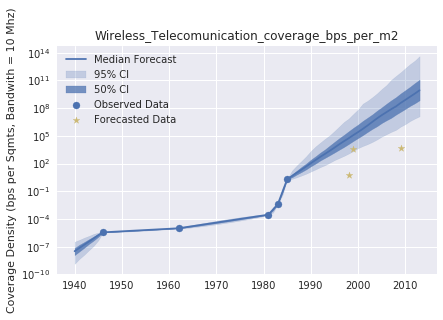

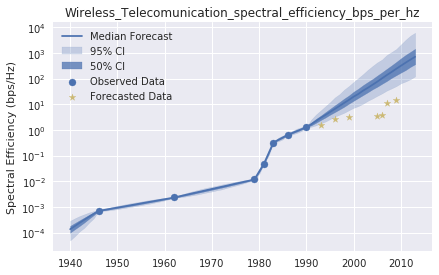

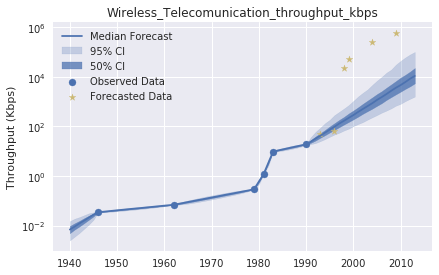

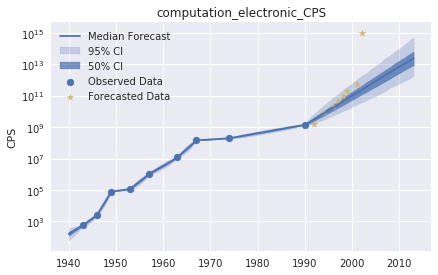

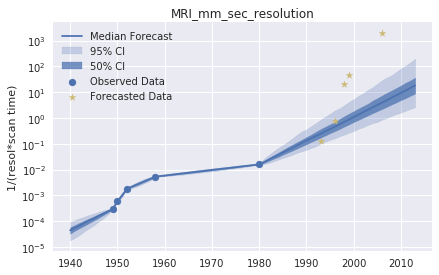

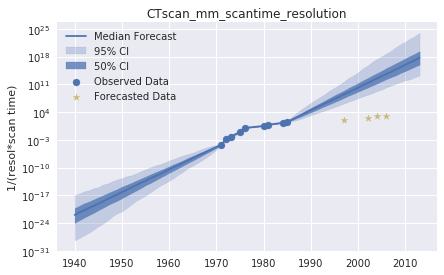

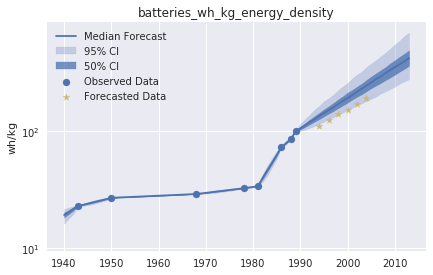

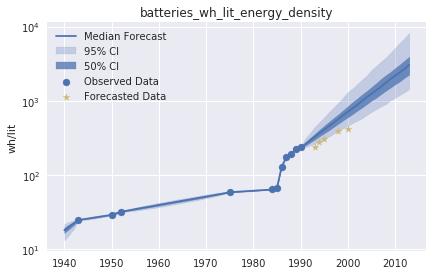

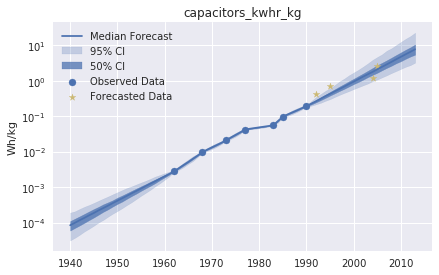

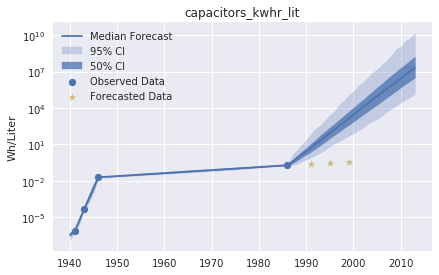

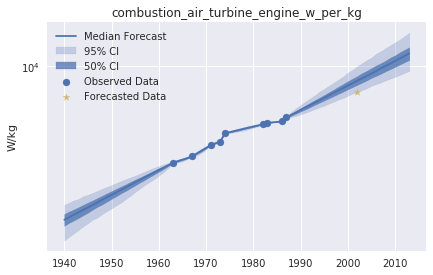

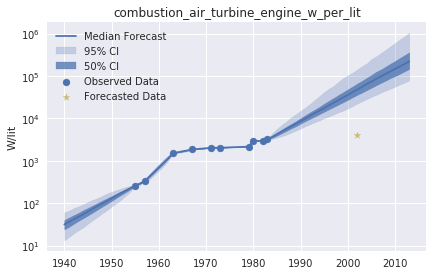

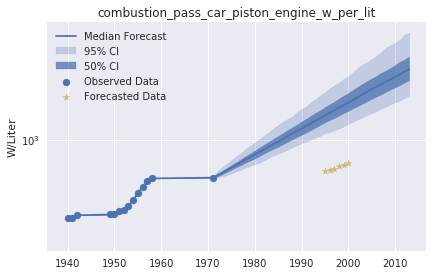

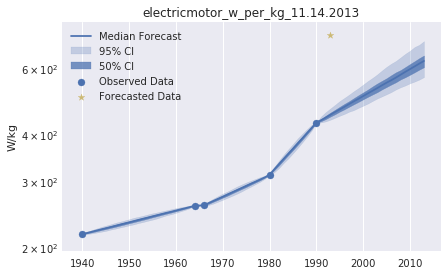

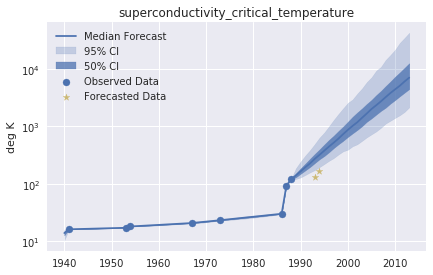

In [842]:
from matplotlib.backends.backend_pdf import PdfPages
plots = PdfPages('/home/jeffrey_alstott/Dropbox/Apps/ShareLaTeX/Forecasting_Technologies/figs/Each_Technology_Forecast.pdf')

for data_type in ['Price', 'Performance']:
    models_to_plot = pickle.load(open('separate_models_forecasts_%s'%data_type, 'rb'))
    model_type = 'ARIMA(0,0)'

    model_of_interest = models_to_plot
    model_of_interest_forecast_quality = test_prediction(model_of_interest[model_type].transpose([1,2,3,0]), 
                                                       model_of_interest['testing'].values)
    print("%i predictions"%(model_of_interest_forecast_quality.shape[0]))

    for (label, dimension) in [('K', 0), ('T', 1), ('D',2)]:
        model_of_interest_forecast_quality[label].replace(arange(len(model_of_interest['testing'].axes[dimension])), 
                                                      model_of_interest['testing'].axes[dimension],
                                                     inplace=True)
    model_of_interest_forecast_quality.set_index(['T', 'K', 'D'], inplace=True)
    CI95 = ((model_of_interest_forecast_quality['percentile']<97.5)*(model_of_interest_forecast_quality['percentile']>2.5))
    print('Portion in 95%% Confidence Interval: %.2f'%CI95.mean())
    CI50 = ((model_of_interest_forecast_quality['percentile']<75)*(model_of_interest_forecast_quality['percentile']>25))
    print('Portion in 50%% Confidence Interval: %.2f'%CI50.mean())

    fig = figure(figsize=(fig_width_two_col,fig_width_two_col/golden))
    import powerlaw
    powerlaw.plot_cdf(2*abs(model_of_interest_forecast_quality['percentile']/100-.5), label='Center CI at 50th Percentile and Expand')
    powerlaw.plot_cdf(model_of_interest_forecast_quality['percentile']/100, label='Start CI at 0th Percentile and Raise')

    # powerlaw.plot_cdf(1-model_of_interest_forecast_quality['percentile']/100, label='Start CI at 100')
    yscale('linear')
    xscale('linear')
    plot((0,1),(0,1), 'k--', label='Perfect Calibration')
    legend()
    xlabel("Forecast Confidence Interval")
    ylabel("Percent of Observations within\nwithin that Confidence Interval")

    filename = "Forecast_Calibration_%s"%data_type
    fig.savefig(figs_directory+filename+'.png', dpi=440)
    fig.savefig(figs_directory+filename+'.pdf', bbox_inches='tight')

    figure()
    CI95.groupby(level='K').mean().hist()
    title("95% Confidence Interval")
    figure()
    CI50.groupby(level='K').mean().hist()
    title("50% Confidence Interval")


    for i in arange(models_to_plot[model_type].shape[1]):
        fig = figure(figsize=(fig_width_two_col, fig_width_two_col/golden))
        plot_time_series_inference(exp(models_to_plot[model_type]), ind=i,D=-1, x=models_to_plot['training'].major_axis, labels=True)
        scatter(models_to_plot['training'].major_axis,exp(models_to_plot['training']).iloc[i,:,-1], label='Observed Data')#, s=1)
        scatter(models_to_plot['training'].major_axis,exp(models_to_plot['testing']).iloc[i,:,-1], marker='*', c='y', label='Forecasted Data')#, s=4)
        title(models_to_plot['training'].items[i])
        yscale('log')
        legend()
        ylabel(metadata.set_index('Name').loc[models_to_plot['training'].items[i], 'Units'])
        plots.savefig(fig, bbox_inches='tight')
plots.close()

In [823]:
data_type = 'Price'
separate_models_forecasts = pickle.load(open('separate_models_forecasts_%s'%data_type, 'rb'))
pooled_models_forecasts = pickle.load(open('pooled_models_forecasts_%s'%data_type, 'rb'))

In [234]:
training_year = 1990
Y_training = separate_models_forecasts['training']

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


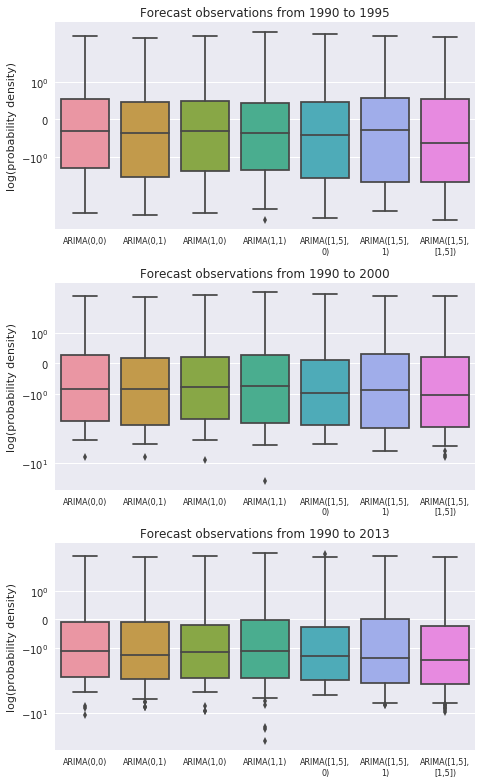

In [235]:
models_to_compare = separate_models_forecasts

horizons = [1995.0,2000.0,2013.0]

fig = figure(figsize=(fig_width_two_col, fig_width_two_col*golden))
n_rows = len(horizons)
n_cols = 1
this_ax = 0

Y_testing = models_to_compare['testing']
for horizon in horizons:
    this_ax +=1
    ax = fig.add_subplot(n_rows, n_cols, this_ax)
    forecast_qualities = {}
    for model_name in models_to_compare.keys():
        if model_name=='testing' or model_name=='training':
            continue
        forecast_qualities[model_name] = test_forecasts(models_to_compare[model_name], 
                                                        Y_testing).loc[:horizon, 'lpdf'].values
    sns.boxplot(data=pd.DataFrame(forecast_qualities),ax=ax)
    ax.set_yscale('symlog')
    ax.set_title("Forecast observations from %i to %i"%(training_year,horizon))
    ax.set_ylabel("log(probability density)")
    ax.set_xticklabels([l.get_text().replace('],', '],\n') for l in ax.get_xticklabels()], fontsize=8)
fig.tight_layout()        

filename = "Separate_Models_Forecast_Quality_%s"%data_type
fig.savefig(figs_directory+filename+'.png', dpi=440)
fig.savefig(figs_directory+filename+'.pdf')

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


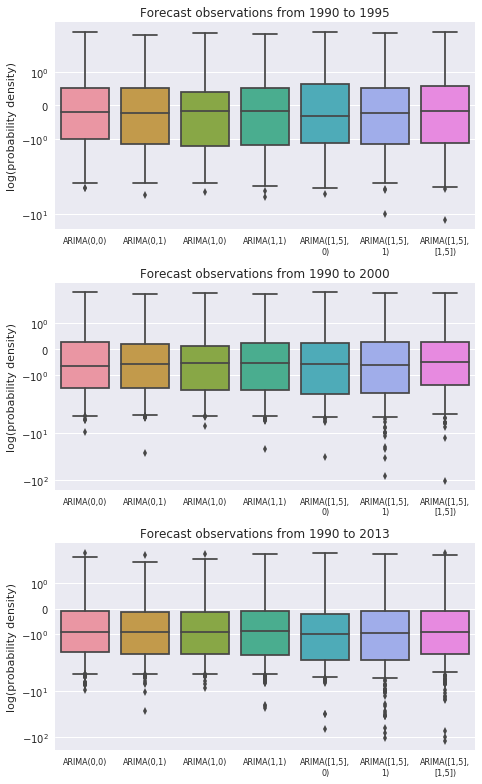

In [236]:
models_to_compare = pooled_models_forecasts

horizons = [1995.0,2000.0,2013.0]

fig = figure(figsize=(fig_width_two_col, fig_width_two_col*golden))
n_rows = len(horizons)
n_cols = 1
this_ax = 0

Y_testing = models_to_compare['testing']
for horizon in horizons:
    this_ax +=1
    ax = fig.add_subplot(n_rows, n_cols, this_ax)
    forecast_qualities = {}
    for model_name in models_to_compare.keys():
        if model_name=='testing' or model_name=='training':
            continue
        forecast_qualities[model_name] = test_forecasts(models_to_compare[model_name], 
                                                        Y_testing).loc[:horizon, 'lpdf'].values
    sns.boxplot(data=pd.DataFrame(forecast_qualities),ax=ax)
    ax.set_yscale('symlog')
    ax.set_title("Forecast observations from %i to %i"%(training_year,horizon))
    ax.set_ylabel("log(probability density)")
    ax.set_xticklabels([l.get_text().replace('],', '],\n') for l in ax.get_xticklabels()], fontsize=8)
fig.tight_layout()        

filename = "Pooled_Models_Forecast_Quality_%s"%data_type
fig.savefig(figs_directory+filename+'.png', dpi=440)
fig.savefig(figs_directory+filename+'.pdf')

47
40
35
31
40


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


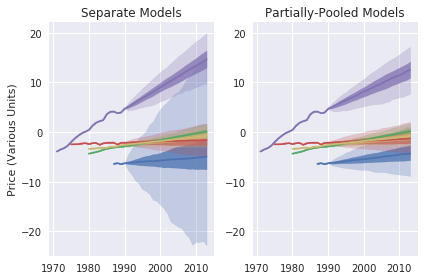

In [825]:
model_type = 'ARIMA(0,0)'
data_type = 'Price'
separate_models_forecasts = pickle.load(open('separate_models_forecasts_%s'%data_type, 'rb'))
pooled_models_forecasts = pickle.load(open('pooled_models_forecasts_%s'%data_type, 'rb'))
fig = figure()

Y_training = separate_models_forecasts['training']

ax = fig.add_subplot(1,2,1)
for i in range(5):
    start = int(Y_training.iloc[i].first_valid_index()-Y_training.major_axis[0])
    print(start)
    plot_time_series_inference(separate_models_forecasts[model_type][:,:,start:],ind=i,x=Y_training.major_axis[start:])
title("Separate Models")
ylabel("%s (Various Units)"%(data_type))


ax = fig.add_subplot(1,2,2, sharey=ax)    
for i in range(5):
    start = int(Y_training.iloc[i].first_valid_index()-Y_training.major_axis[0])
    plot_time_series_inference(pooled_models_forecasts[model_type][:,:,start:],ind=i,x=Y_training.major_axis[start:])
title("Partially-Pooled Models")

fig.tight_layout()        
filename = "Separate_vs_Pooled_Extrapolation_Demonstration_%s"%data_type
fig.savefig(figs_directory+filename+'.png', dpi=440)
fig.savefig(figs_directory+filename+'.pdf')

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


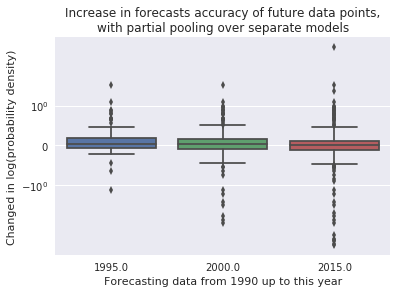

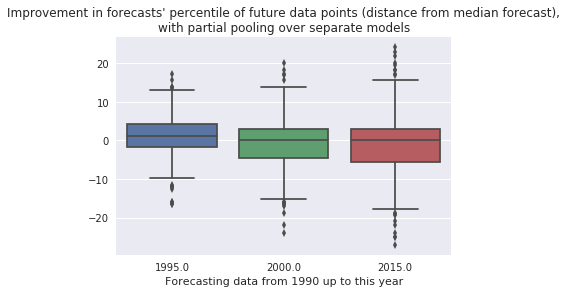

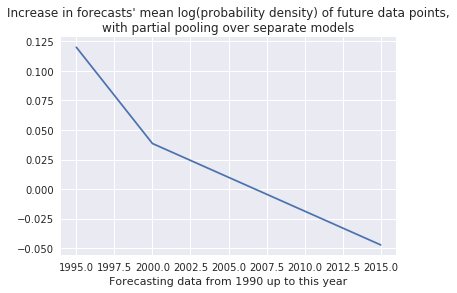

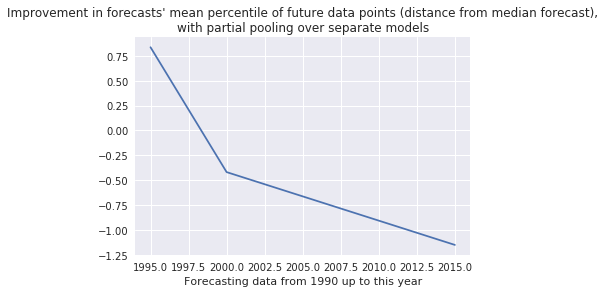

In [238]:
Y_testing = separate_models_forecasts['testing']

separate_models_forecast_quality = test_prediction(separate_models_forecasts[model_type].transpose([1,2,3,0]), Y_testing.values)
pooled_models_forecast_quality = test_prediction(pooled_models_forecasts[model_type].transpose([1,2,3,0]), Y_testing.values)

for (label, dimension) in [('K', 0), ('T', 1), ('D',2)]:
    pooled_models_forecast_quality[label].replace(arange(len(Y_testing.axes[dimension])), 
                                                  Y_testing.axes[dimension],
                                                 inplace=True)
    
    separate_models_forecast_quality[label].replace(arange(len(Y_testing.axes[dimension])), 
                                                  Y_testing.axes[dimension],
                                                 inplace=True)
pooled_models_forecast_quality.set_index(['T', 'K', 'D'], inplace=True)
pooled_models_forecast_quality.sort_index(inplace=True)
separate_models_forecast_quality.set_index(['T', 'K', 'D'], inplace=True)
separate_models_forecast_quality.sort_index(inplace=True)

forecast_quality_difference = separate_models_forecast_quality.copy()
forecast_quality_difference['lpdf'] = pooled_models_forecast_quality['lpdf']-separate_models_forecast_quality['lpdf']
forecast_quality_difference['percentile'] = abs(50-separate_models_forecast_quality['percentile'])-abs(50-pooled_models_forecast_quality['percentile'])

horizons = [1995.0,2000.0,2015.0]
lpdfs = []
percentiles = []
for horizon in horizons:
    lpdfs.append(forecast_quality_difference.loc[:horizon, 'lpdf'])
    percentiles.append(forecast_quality_difference.loc[:horizon, 'percentile'])

sns.boxplot(data=lpdfs)
gca().set_xticklabels(horizons)
title("Increase in forecasts accuracy of future data points,\nwith partial pooling over separate models")
ylabel("Changed in log(probability density)")
xlabel("Forecasting data from %i up to this year"%training_year)
yscale('symlog')
figure()
sns.boxplot(data=percentiles)
gca().set_xticklabels(horizons)
title("Improvement in forecasts' percentile of future data points (distance from median forecast),\nwith partial pooling over separate models")
xlabel("Forecasting data from %i up to this year"%training_year)

figure()
lpdfs = []
percentiles = []
for horizon in horizons:
    lpdfs.append(forecast_quality_difference.loc[:horizon, 'lpdf'].mean())
    percentiles.append(forecast_quality_difference.loc[:horizon, 'percentile'].mean())

plot(horizons, lpdfs)
title("Increase in forecasts' mean log(probability density) of future data points,\nwith partial pooling over separate models")
xlabel("Forecasting data from %i up to this year"%training_year)
figure()
plot(horizons, percentiles)
title("Improvement in forecasts' mean percentile of future data points (distance from median forecast),\nwith partial pooling over separate models")
xlabel("Forecasting data from %i up to this year"%training_year)

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


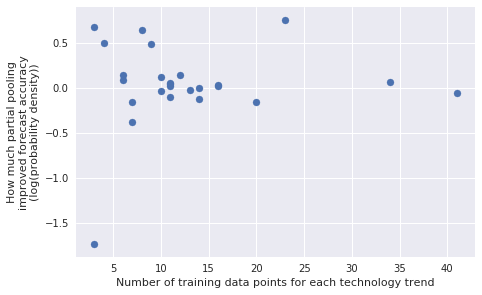

In [265]:
fig = figure(figsize=(fig_width_two_col, fig_width_two_col/golden))
scatter(Y_training.notnull().sum(axis=1).T.sort_index(),
        forecast_quality_difference.groupby(level='K')['lpdf'].mean().sort_index()
       )
ylabel("How much partial pooling\nimproved forecast accuracy\n(log(probability density))")
xlabel("Number of training data points for each technology trend")

fig.tight_layout()        
filename = "Separate_vs_Pooled_Forecast_Accuracy_%s"%data_type
fig.savefig(figs_directory+filename+'.png', dpi=440)
fig.savefig(figs_directory+filename+'.pdf')

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/fon

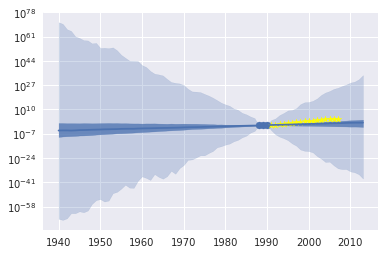

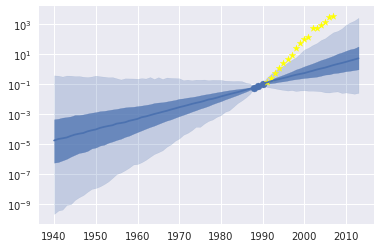

In [264]:
data_type = 'Price'
model_type = 'ARIMA(0,0)'

target_technology = forecast_quality_difference.groupby(level='K')['lpdf'].mean().argmin()

for models_to_plot in [pickle.load(open('separate_models_forecasts_%s'%data_type, 'rb')),
                        pickle.load(open('pooled_models_forecasts_%s'%data_type, 'rb'))]:
    figure()
    target_technology_ind = where(models_to_plot['testing'].items==target_technology)[0][0]
    plot_time_series_inference(exp(models_to_plot[model_type]), ind=target_technology_ind,D=-1, x=models_to_plot['training'].major_axis)
    scatter(models_to_plot['training'].major_axis,exp(models_to_plot['training']).iloc[target_technology_ind,:,-1])#, s=1)
    scatter(models_to_plot['training'].major_axis,exp(models_to_plot['testing']).iloc[target_technology_ind,:,-1], 
            marker='*', c='yellow')#, s=4)
    yscale('log')

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


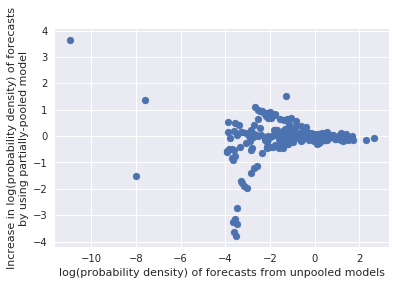

In [240]:
scatter(separate_models_forecast_quality['lpdf'], forecast_quality_difference['lpdf'])
xlabel("log(probability density) of forecasts from unpooled models")
ylabel("Increase in log(probability density) of forecasts\nby using partially-pooled model")
# title("Partial pooling helps the most in those instances\nwhere an unpooled model really messed up.")

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


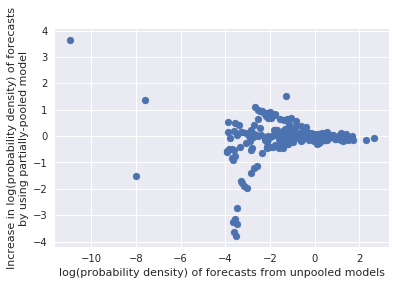

In [132]:
scatter(separate_models_forecast_quality['lpdf'], forecast_quality_difference['lpdf'])
xlabel("log(probability density) of forecasts from unpooled models")
ylabel("Increase in log(probability density) of forecasts\nby using partially-pooled model")
# title("Partial pooling helps the most in those instances\nwhere an unpooled model really messed up.")

VAR model
===


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


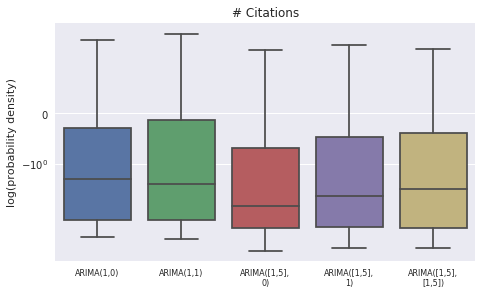

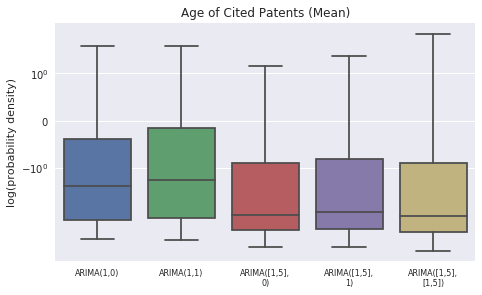

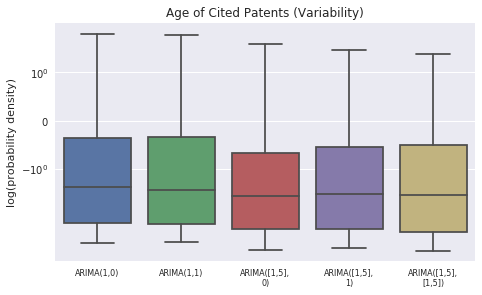

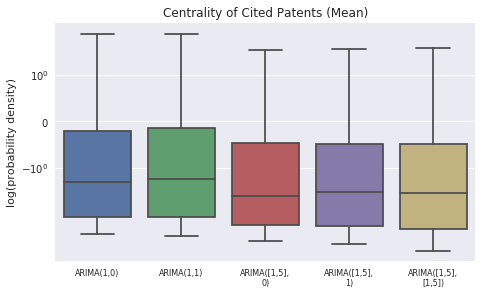

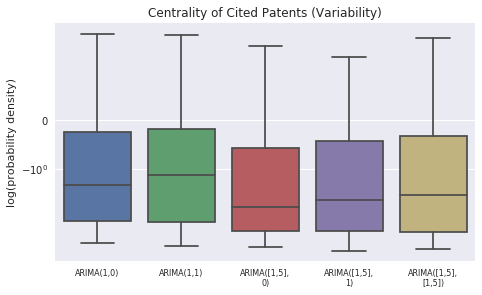

In [289]:
data_type = 'Price'

for target_predictor in candidate_predictors:
    VAR_models_forecasts = pickle.load(open('VAR_%s_separate_models_forecasts_%s'%(target_predictor, data_type), 'rb'))
    
    models_to_compare = VAR_models_forecasts

    horizons = [2013.0]

    fig = figure(figsize=(fig_width_two_col, fig_width_two_col/golden))
    n_rows = len(horizons)
    n_cols = 1
    this_ax = 0

    Y_testing = models_to_compare['testing']
    for horizon in horizons:
        this_ax +=1
        if this_ax>1:
            ax = fig.add_subplot(n_rows, n_cols, this_ax,sharey=ax)
        else:
            ax = fig.add_subplot(n_rows, n_cols, this_ax)
        forecast_qualities = {}
        for model_name in models_to_compare.keys():
            if model_name=='testing' or model_name=='training':
                continue
            forecast_qualities[model_name] = test_forecasts(models_to_compare[model_name], 
                                                            Y_testing).xs(data_type, 
                                                                          level='D').loc[:horizon, 
                                                                                         'lpdf'].values
        sns.boxplot(data=pd.DataFrame(forecast_qualities),ax=ax)
        ax.set_yscale('symlog')
#         ax.set_title("Forecast observations from %i to %i"%(training_year,horizon))
        ax.set_title(predictor_renaming[target_predictor])
        ax.set_ylabel("log(probability density)")
        ax.set_xticklabels([l.get_text().replace('],', '],\n') for l in ax.get_xticklabels()], fontsize=8)
    fig.tight_layout()       
#     fig.suptitle(target_predictor)

    filename = "VAR_Model_Prediction_%s_%s"%(target_predictor, data_type)
    fig.savefig(figs_directory+filename+'.png', dpi=440)
    fig.savefig(figs_directory+filename+'.pdf')

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


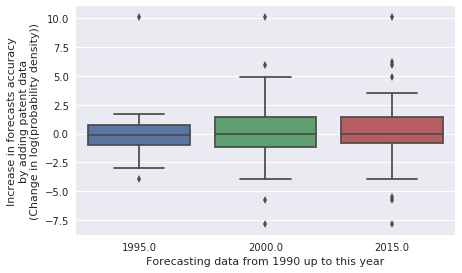

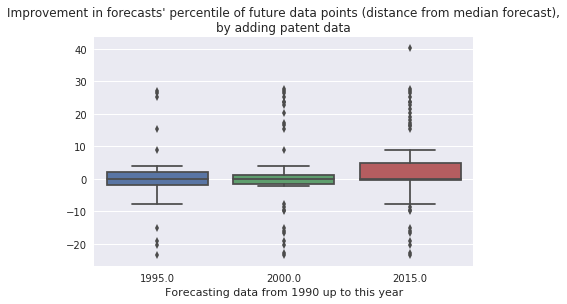

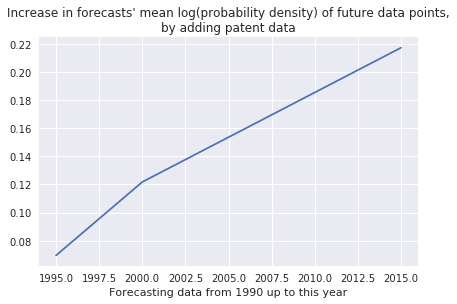

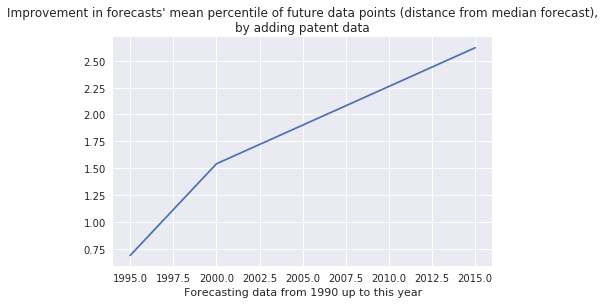

In [291]:
data_type = 'Performance'
model_type = 'ARIMA(1,0)'

model_1 = separate_models_forecasts = pickle.load(open('separate_models_forecasts_%s'%data_type, 'rb'))
model_1 = test_forecasts(model_1[model_type], model_1['testing'])
target_predictor = 'meanSPNPcited_1year_before'
model_2 = pickle.load(open('VAR_%s_separate_models_forecasts_%s'%(target_predictor, data_type), 'rb'))
model_2 = test_forecasts(model_2[model_type], model_2['testing'])
    
forecast_quality_difference = model_1.copy()
forecast_quality_difference['lpdf'] = model_2['lpdf']-model_1['lpdf']
forecast_quality_difference['percentile'] = abs(50-model_1['percentile'])-abs(50-model_2['percentile'])

horizons = [1995.0,2000.0,2015.0]
lpdfs = []
percentiles = []
for horizon in horizons:
    lpdfs.append(forecast_quality_difference.loc[:horizon, 'lpdf'])
    percentiles.append(forecast_quality_difference.loc[:horizon, 'percentile'])

fig = figure(figsize=(fig_width_two_col, fig_width_two_col/golden))
sns.boxplot(data=lpdfs)
gca().set_xticklabels(horizons)
ylabel("Increase in forecasts accuracy\nby adding patent data"
       "\n(Change in log(probability density))")
xlabel("Forecasting data from %i up to this year"%training_year)
# yscale('symlog')

filename = "VAR_Model_Prediction_increase_%s"%data_type
fig.savefig(figs_directory+filename+'.png', dpi=440)
fig.savefig(figs_directory+filename+'.pdf', bbox_inches='tight')

figure()
sns.boxplot(data=percentiles)
gca().set_xticklabels(horizons)
title("Improvement in forecasts' percentile of future data points (distance from median forecast),\nby adding patent data")
xlabel("Forecasting data from %i up to this year"%training_year)

figure()
lpdfs = []
percentiles = []
for horizon in horizons:
    lpdfs.append(forecast_quality_difference.loc[:horizon, 'lpdf'].mean())
    percentiles.append(forecast_quality_difference.loc[:horizon, 'percentile'].mean())

plot(horizons, lpdfs)
title("Increase in forecasts' mean log(probability density) of future data points,\nby adding patent data")
xlabel("Forecasting data from %i up to this year"%training_year)
figure()
plot(horizons, percentiles)
title("Improvement in forecasts' mean percentile of future data points (distance from median forecast),\nby adding patent data")
xlabel("Forecasting data from %i up to this year"%training_year)

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


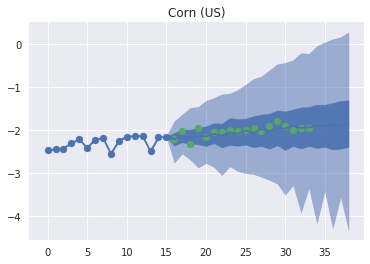

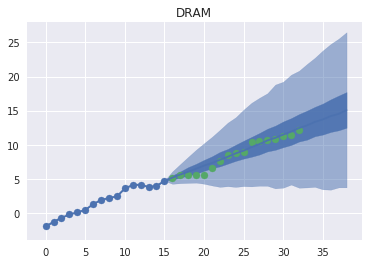

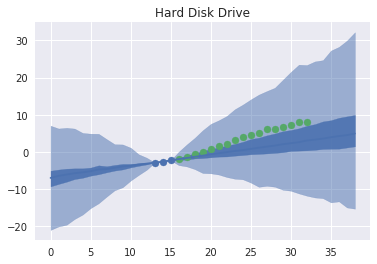

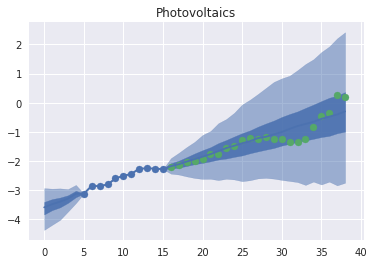

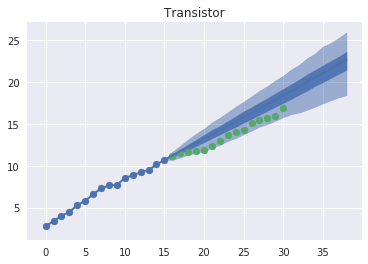

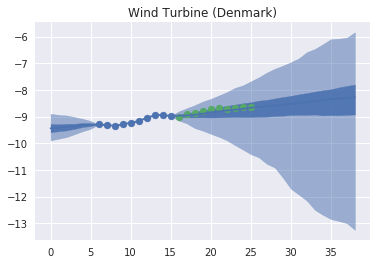

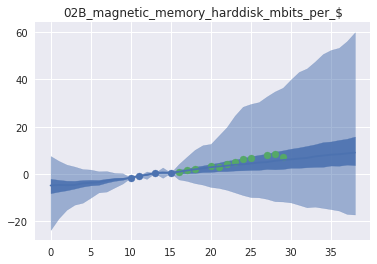

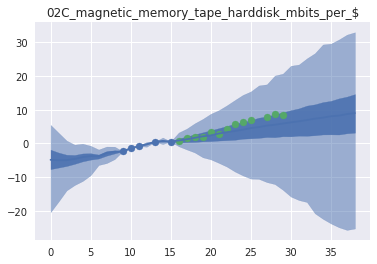

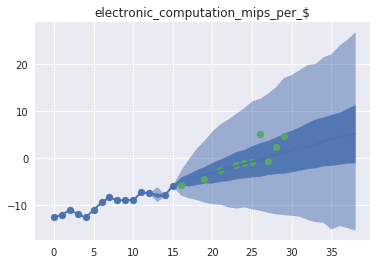

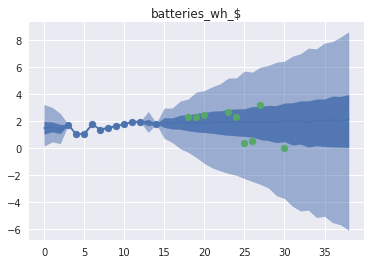

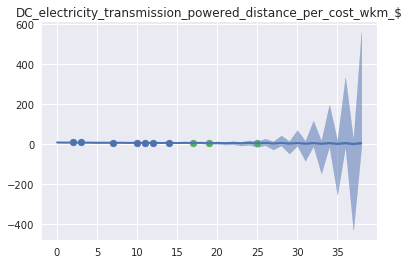

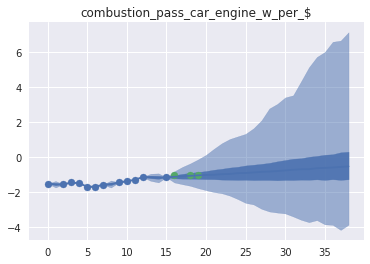

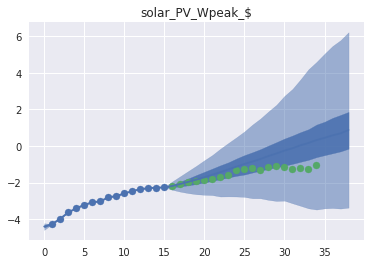

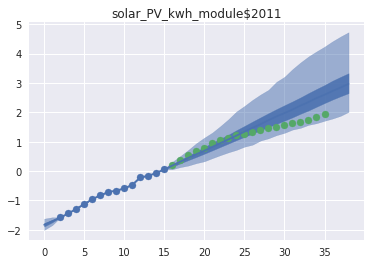

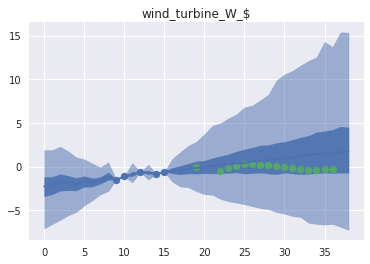

In [136]:
VAR_models_forecasts = pickle.load(open('VAR_%s_separate_models_forecasts_%s'%(target_predictor, data_type), 'rb'))

for i in arange(VAR_models_forecasts[('ARIMA(1,1)')].shape[1]):
    figure()
    plot_time_series_inference(VAR_models_forecasts[('ARIMA(1,0)')], ind=i,D=-1)
    scatter(arange(VAR_models_forecasts['training'].shape[1]),VAR_models_forecasts['training'].iloc[i,:,-1])
    scatter(arange(VAR_models_forecasts['testing'].shape[1]),VAR_models_forecasts['testing'].iloc[i,:,-1])
    title(VAR_models_forecasts['training'].items[i])

In [ ]:
Y_var = pd.Panel(items=Y.columns,
                      major_axis=Y.index,
                      minor_axis=candidate_predictors,#+['Performance'],
                     )
from scipy.special import logit

for predictor in candidate_predictors:
    print(predictor)
    for col in Y.columns:
        if metadata.set_index('Name').notnull().loc[col, 'Domain']:
            Y_var.loc[col,:, predictor] = logit(predictors_by_domain.loc[metadata.set_index('Name').loc[col, 
                                                                                                   'Domain']][predictor])
# predictors.fillna(0, inplace=True)
Y_var.loc[:,:, 'Performance'] = Y

# combined_df = Y.stack(dropna=False).swaplevel()
# combined_df.name = 'Performance'
# combined_df = pd.DataFrame(combined_df)

has_patent_data = Y_var.notnull().any().loc['Citations_Backward_N']
has_patent_data = has_patent_data[has_patent_data].index.values
Y_var = Y_var.loc[has_patent_data]

In [ ]:
Y_var_training = Y_var.copy()
Y_var_testing = Y_var.copy()
Y_var_training.loc[:,training_year+1:] = nan
Y_var_testing.loc[:,:training_year] = nan

# Y_testing = Y_testing[time_series_has_data[:10]]
# Y_training = Y_training[time_series_has_data[:10]]

In [ ]:
model = TimeSeriesModel(Y=Y_var_training.values, difference=ones(5), p=[1,5,10], q=[1,5,10], use_partial_pooling=True)
start_time = time()
max_depth = 15
model.sampling(n_jobs=n_jobs, iter=n_iterations, control={'max_treedepth':max_depth})
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))
test_model_fit(model.fit, ['mu', 'sigma'], max_depth=max_depth)

VAR_models_forecast = model.fit['Y_latent']

In [ ]:
VAR_models_forecast_quality = test_prediction(VAR_models_forecast.transpose([1,2,3,0])[:,:,5:], 
                                              Y_var_testing.iloc[:,:,5:].values)

for (label, dimension) in [('K', 0), ('T', 1), ('D', 2)]:
    VAR_models_forecast_quality[label].replace(arange(len(Y_var_testing.axes[dimension])), 
                                                  Y_var_testing.axes[dimension],
                                                 inplace=True)

VAR_models_forecast_quality.set_index(['T', 'K', 'D'], inplace=True)
VAR_models_forecast_quality.sort_index(inplace=True)

forecast_quality_difference = VAR_models_forecast_quality.copy()
forecast_quality_difference['lpdf'] = pooled_models_forecast_quality['lpdf']-VAR_models_forecast_quality['lpdf']
forecast_quality_difference['percentile'] = abs(50-VAR_models_forecast_quality['percentile'])-abs(50-pooled_models_forecast_quality['percentile'])

horizons = [1995.0,2000.0,2015.0]
lpdfs = []
percentiles = []
for horizon in horizons:
    lpdfs.append(forecast_quality_difference.loc[:horizon, 'lpdf'])
    percentiles.append(forecast_quality_difference.loc[:horizon, 'percentile'])

sns.boxplot(data=lpdfs)
gca().set_xticklabels(horizons)
ylabel("Increase in forecasts' ln(probability density) of future data points,\nwith partial pooling over separate models")
xlabel("Forecasting data from %i up to this year"%training_year)
yscale('symlog')
figure()
sns.boxplot(data=percentiles)
gca().set_xticklabels(horizons)
ylabel("Improvement in forecasts' percentile of future data points (distance from median forecast),\nwith partial pooling over separate models")
xlabel("Forecasting data from %i up to this year"%training_year)

figure()
lpdfs = []
percentiles = []
for horizon in horizons:
    lpdfs.append(forecast_quality_difference.loc[:horizon, 'lpdf'].mean())
    percentiles.append(forecast_quality_difference.loc[:horizon, 'percentile'].mean())

plot(horizons, lpdfs)
ylabel("Increase in forecasts' mean ln(probability density) of future data points,\nwith partial pooling over separate models")
xlabel("Forecasting data from %i up to this year"%training_year)
figure()
plot(horizons, percentiles)
ylabel("Improvement in forecasts' mean percentile of future data points (distance from median forecast),\nwith partial pooling over separate models")
xlabel("Forecasting data from %i up to this year"%training_year)

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


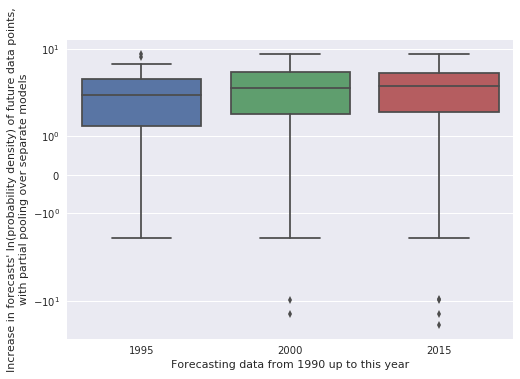

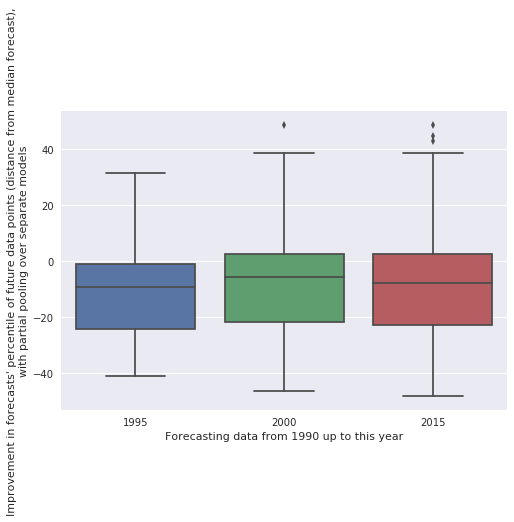

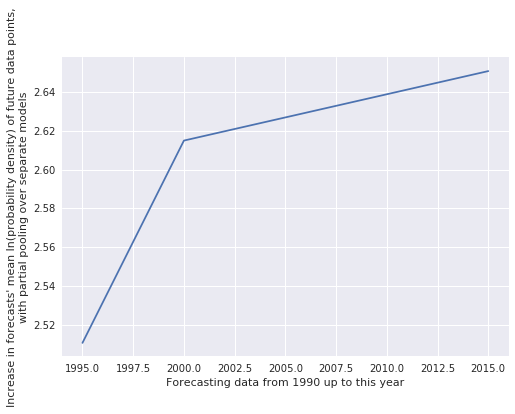

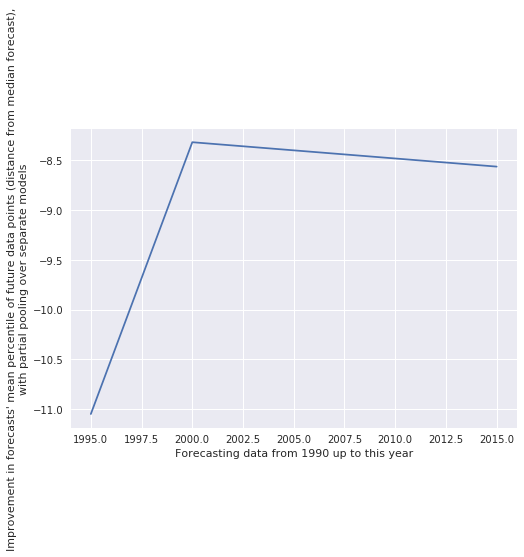

In [345]:
VAR_models_forecast_quality = test_prediction(VAR_models_forecast.transpose([1,2,3,0])[:,:,5:], 
                                              Y_var_testing.iloc[:,:,5:].values)

forecast_quality_difference = VAR_models_forecast_quality.copy()
forecast_quality_difference['lpdf'] = pooled_models_forecast_quality['lpdf']-VAR_models_forecast_quality['lpdf']
forecast_quality_difference['percentile'] = abs(50-VAR_models_forecast_quality['percentile'])-abs(50-pooled_models_forecast_quality['percentile'])

horizons = [1995,2000,2015]
lpdfs = []
percentiles = []
for horizon in horizons:
    ind = forecast_quality_difference['T']<(horizon-data_start_year)
    lpdfs.append(forecast_quality_difference[ind]['lpdf'])
    percentiles.append(forecast_quality_difference[ind]['percentile'])

sns.boxplot(data=lpdfs)
gca().set_xticklabels(horizons)
ylabel("Increase in forecasts' ln(probability density) of future data points,\nwith partial pooling over separate models")
xlabel("Forecasting data from %i up to this year"%training_year)
yscale('symlog')
figure()
sns.boxplot(data=percentiles)
gca().set_xticklabels(horizons)
ylabel("Improvement in forecasts' percentile of future data points (distance from median forecast),\nwith partial pooling over separate models")
xlabel("Forecasting data from %i up to this year"%training_year)

figure()
lpdfs = []
percentiles = []
for horizon in horizons:
    ind = forecast_quality_difference['T']<(horizon-data_start_year)
    lpdfs.append(forecast_quality_difference[ind]['lpdf'].mean())
    percentiles.append(forecast_quality_difference[ind]['percentile'].mean())

plot(horizons, lpdfs)
ylabel("Increase in forecasts' mean ln(probability density) of future data points,\nwith partial pooling over separate models")
xlabel("Forecasting data from %i up to this year"%training_year)
figure()
plot(horizons, percentiles)
ylabel("Improvement in forecasts' mean percentile of future data points (distance from median forecast),\nwith partial pooling over separate models")
xlabel("Forecasting data from %i up to this year"%training_year)

ValueError: x and y must be the same size

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


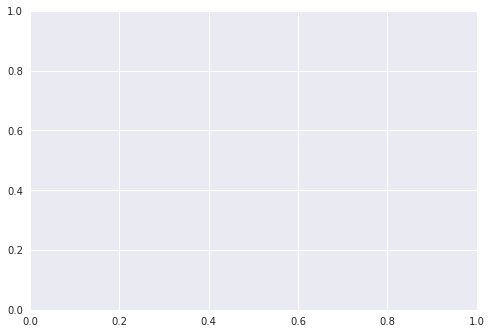

In [346]:
scatter(pooled_models_forecast_quality['lpdf'], forecast_quality_difference['lpdf'])
xlabel("log(probability density) of forecasts from unpooled models")
ylabel("Increase in log(probability density) of forecasts\nby using partially-pooled model")
title("Partial pooling helps the most in those instances\nwhere an unpooled model really messed up.")

Fitting took 1.84 minutes
"0 of 1000 iterations saturated the maximum tree depth of 15 (0.0%)"
"Chain 0: E-BFMI = 0.18196385853365457"
"E-BFMI below 0.2 indicates you may need to reparameterize your model"
"Chain 1: E-BFMI = 0.24683462117712912"
"Chain 2: E-BFMI = 0.09203346271462351"
"E-BFMI below 0.2 indicates you may need to reparameterize your model"
"Chain 3: E-BFMI = 0.1327770134667338"
"E-BFMI below 0.2 indicates you may need to reparameterize your model"
"No divergences"


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


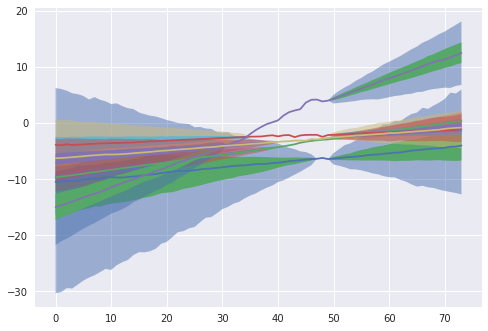

In [20]:
model = TimeSeriesModel(Y=Y_training,difference=[1], use_partial_pooling=True)
start_time = time()
max_depth = 15
model.sampling(n_jobs=n_jobs, iter=n_iterations, control={'max_treedepth':max_depth})
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))
test_model_fit(model.fit, ['mu', 'sigma'], max_depth=max_depth)

for i in range(Y_training.shape[1]):
    plot_time_series_inference(model.fit['Y_latent'],ind=i)

In [50]:
def train_model_years(time_series, training_years,**model_args):
    models = {}
    
    for training_year in training_years:
        print(training_year)
        
        Y_training = time_series.copy()
        Y_testing = time_series.copy()
        Y_training.loc[training_year:] = nan
        Y_testing.loc[:training_year] = nan

        time_series_has_data = (Y_training.notnull().sum(axis=0)>=3) & (Y_testing.notnull().sum(axis=0)>0)
        if time_series_has_data.empty:
            models[training_year] = None
            continue
        print("%i time series"%(len(time_series_has_data)))
        time_series_has_data = time_series_has_data[time_series_has_data].index
        
        Y_testing = Y_testing[time_series_has_data]
        Y_training = Y_training[time_series_has_data]

        model = TimeSeriesModel(Y=Y_training.values, **model_args)
        model.sampling(n_jobs=n_jobs, iter=n_iterations, control={'max_treedepth':max_depth})
        models[training_year] = model
    return models

In [ ]:
training_years = [1975, 1985, 1995, 2005]
data_starting_year = 1940

target_tech_names = metadata.ix[metadata['Type']=='Price', 'Name']
Y = log(empirical_time_series[target_tech_names])
Y = Y.loc[data_starting_year:]


model_types = [('ARMA(1,0)', {'p':1,'q':0}),
               ('ARMA(1,1)', {'p':1,'q':1}),
               ('ARMA(2,0)', {'p':2,'q':0}),
               ('ARMA(2,1)', {'p':2,'q':1}),
               ('ARMA(2,2)', {'p':2,'q':2}),
              ]

models = {}
for model_name, model_args in model_types:
    print(model_name)
    model = train_model_years(Y, 
                              training_years, 
                              use_partial_pooling=True, difference=[1], 
                              **model_args)
    models[model_name] = model

ARMA(1,0)
1975
1985
1995
2005
ARMA(1,1)
1975


In [227]:
df = pd.concat({'a': Y, 'b':Y})
## Use this to create a multiindex of the performance/patent data, across each technology

(148, 86)

In [176]:
training_year = 1995

In [155]:
fit = models['ARMA(1,1)'][training_year].fit

In [202]:
q = pd.Panel({'performance': Y})

In [ ]:
def test_forecast(fit, Y, Y_pred='Y_latent', training_year):
    Y_testing = Y[time_series_has_data].copy()
    Y_testing[:training_year] = nan
    Y_testing = Y_testing.T
    
    if Y_testing.ndim==2:
        Y_testing = expand_dims(Y_testing,-1)
    predictions_df = test_prediction(fit, Y_testing, Y_pred)
    return predictions_df

In [207]:
q = q.copy()
q.loc[:,training_year:] = nan

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':


In [ ]:
test_prediction()

In [ ]:
def portion_of_prediction_within_CI(model_fit, Y_testing, Y_pred='Y_latent', lower=2.5, upper=97.5):
    if data.ndim<2:
        a = array((list(map(percentileofscore, model_fit[parameter].T, data))))
        return mean((lower<a)*(a<upper))
    else:
        values = empty(data.shape[1])
        for i in range(data.shape[1]):
            a = array((list(map(percentileofscore, model_fit[parameter][:,i], data.iloc[:,i]))))
            values[i]=nanmean((lower<a)*(a<upper))
        return values
    
def test_prediction(model.fit, Y_testing, Y_pred='Y_latent', horizon=None):
        times, techs = where(Y_testing.notnull())
        model.fit[Y_pred]
#             techs_to_forecast = techs[(forecast_start_ind<times)*(times<forecast_stop_ind)]
#             times_to_forecast = times[(forecast_start_ind<times)*(times<forecast_stop_ind)]
        lpd = list(map(lambda x,y: x.logpdf(y)[0], 
                       map(gaussian_kde, Y_sim[:,techs,times,:].T), 
                       time_series[time_series_from_time_period].values[times_to_forecast, techs_to_forecast]))

        lpd = array(lpd)
        lpd[lpd==-inf] = log(finfo('d').tiny)
        lpd = pd.groupby(pd.Series(lpd),techs_to_forecast).sum()
        lpd = lpd.reindex(arange(len(time_series_from_time_period)))
        lpd.index = time_series_from_time_period
        technology_forecast_models_log_pd[model_name].ix[time_series_from_time_period,
                                                             horizon,training_year] = lpd
        CI95 = portion_of_forecast_within_CI(model.fit, Y_pred, 
                                             Y_testing.values)

In [ ]:
target_tech_names = metadata.ix[metadata['Type']=='Performance', 'Name']

models_performance = {}
for model_name, model_args in model_types:
    print(model_name)
    model = train_model_years(log(empirical_time_series[target_tech_names]).loc[data_starting_year:], 
                              training_years, 
                              use_partial_pooling=True, difference=[1], monotonic=[1],
                              **model_args)
    models_performance[model_name] = model

In [ ]:
target_tech_names = metadata.ix[metadata['Type']=='Performance', 'Name']

models_performance_student = {}
for model_name, model_args in model_types:
    print(model_name)
    model = train_model_years(log(empirical_time_series[target_tech_names]).loc[data_starting_year:], 
                              training_years, 
                              use_partial_pooling=True, difference=[1], monotonic=[1], use_student=True,
                              **model_args)
    models_performance_student[model_name] = model

In [ ]:
target_tech_names = metadata.ix[metadata['Type']=='Price', 'Name']

models_price_student = {}
for model_name, model_args in model_types:
    print(model_name)
    model = train_model_years(log(empirical_time_series[target_tech_names]).loc[data_starting_year:], 
                              training_years, 
                              use_partial_pooling=True, difference=[1], use_student=True,
                              **model_args)
    models_price_student[model_name] = model

In [ ]:
training_year = 1995
fit = models['ARIMA (1,1)'][training_year].fit

In [126]:
predictions_df

Empty DataFrame
Columns: [K, T, D, lpdf, percentile]
Index: []

In [ ]:
technology_forecast_models_log_pd = {}
technology_forecast_models_95CI = {}
technology_forecast_models_fit = {}

def predict_with_model(model_name,
                       model_args,
                       time_series,
                       training_years,
                       horizons,
                       time_series_from_each_time_period,
                       technology_forecast_models_log_pd,
#                        technology_forecast_models_parameters,
                       technology_forecast_models_95CI,
#                        technology_forecast_models_Y_sim,
                       technology_forecast_models_fit, 
#                        target_tech_names,
                       model_code=None, 
                       model_parameters=None,
                       parameter_priors=None,
                       print_output=True):
    from scipy.stats import gaussian_kde
    technology_forecast_models_log_pd[model_name] = pd.Panel(items=time_series.columns,
         major_axis=horizons, 
         minor_axis=training_years)
    technology_forecast_models_95CI[model_name] = pd.Panel(items=time_series.columns,
         major_axis=horizons, 
         minor_axis=training_years)
    
#     technology_forecast_models_parameters[model_name] = pd.Panel(items=target_tech_names,
#              major_axis=model_parameters, 
#              minor_axis=training_years)
#     technology_forecast_models_Y_sim[model_name] = {}
    technology_forecast_models_fit[model_name] = {}
    
    for training_year in training_years:
        print(training_year)
        
        Y_training = time_series.copy()
        Y_testing = time_series.copy()
        Y_training.loc[training_year:] = nan
        Y_testing.loc[:training_year] = nan

        time_series_has_data = (Y_training.notnull().sum(axis=0)>=3) & (Y_testing.notnull().sum(axis=0)>0)
        time_series_has_data = time_series_has_data[time_series_has_data].index
        
        Y_testing = Y_testing[time_series_has_data]
        Y_training = Y_training[time_series_has_data]

        model = TimeSeriesModel(Y=Y_training.values, **model_args)
        model.sampling(n_jobs=n_jobs, iter=n_iterations, control={'max_treedepth':max_depth})
        technology_forecast_models_fit[model_name] = model
        test_model_fit(model.fit, ['mu', 'sigma'], max_depth=max_depth)
        
        ###
        Y_sim = model.fit['Y_latent']
#         technology_forecast_models_Y_sim[model_name][training_year] = Y_sim
        
#         if print_output:
#             print(_print_stanfit(model_fit, model_parameters))
            
        technology_forecast_models_fit[model_name] = model
#         for parameter in model_parameters:
#             technology_forecast_models_parameters[model_name]
#             p = model_fit[parameter].mean(axis=0)

#             if type(p)==numpy.ndarray:
#                 for i in range(len(p)):
#                     technology_forecast_models_parameters[model_name].ix[time_series_from_time_period, 
#                                                         parameter+'_%i'%i,
#                                                         training_year] = p[i]
#             else:        
#                 technology_forecast_models_parameters[model_name].ix[time_series_from_time_period, 
#                                                             parameter,
#                                                             training_year] = p

        for horizon in horizons:
            if horizon=='all':
                forecast_stop_ind = time_series.shape[0]
            else:
                forecast_stop_ind = horizon+forecast_start_ind
            
            times, techs = where(Y_testing.notnull())
#             techs_to_forecast = techs[(forecast_start_ind<times)*(times<forecast_stop_ind)]
#             times_to_forecast = times[(forecast_start_ind<times)*(times<forecast_stop_ind)]
            lpd = list(map(lambda x,y: x.logpdf(y)[0], 
                           map(gaussian_kde, Y_sim[:,techs,times,:].T), 
                           time_series[time_series_from_time_period].values[times_to_forecast, techs_to_forecast]))

            lpd = array(lpd)
            lpd[lpd==-inf] = log(finfo('d').tiny)
            lpd = pd.groupby(pd.Series(lpd),techs_to_forecast).sum()
            lpd = lpd.reindex(arange(len(time_series_from_time_period)))
            lpd.index = time_series_from_time_period
            technology_forecast_models_log_pd[model_name].ix[time_series_from_time_period,
                                                                 horizon,training_year] = lpd
            CI95 = portion_of_forecast_within_CI(model_fit, Y_testing, 'Y_latent', horizon = training_year'Y_sim', 
                                                 time_series[time_series_from_time_period].values, 
                                                 forecast_start_ind, 
                                                 forecast_stop_ind)
            technology_forecast_models_95CI[model_name].ix[time_series_from_time_period,
                                                           horizon,training_year] = CI95

Fitting took 0.12 minutes
mu
"100% of values recovered"
"Maximum Rhat of 1.00"
sigma
"100% of values recovered"
"Maximum Rhat of 1.00"
"0 of 1000 iterations saturated the maximum tree depth of 15 (0.0%)"
"Chain 0: E-BFMI = 0.8232473282310577"
"Chain 1: E-BFMI = 0.9879603430233724"
"Chain 2: E-BFMI = 0.9791939891526468"
"Chain 3: E-BFMI = 1.0378176858622834"
"No divergences"
Inference for Stan model: anon_model_287fe33c577d8fab0f9d0d0c2ba2fd8e.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0,0]             3.93  3.2e-3    0.1   3.73   3.87   3.94    4.0   4.13   1000    1.0
mu[1,0]             4.07  3.4e-3   0.11   3.87    4.0   4.07   4.14   4.28   1000    1.0
mu[2,0]             3.93  3.5e-3   0.11   3.71   3.86   3.92    4.0   4.15   1000    1.0
mu[3,0]             4.09  3.5e-3   0.11   3.88   4.02   4.09   4.16   4.32   1000

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


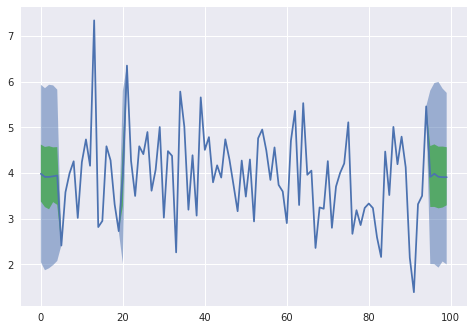

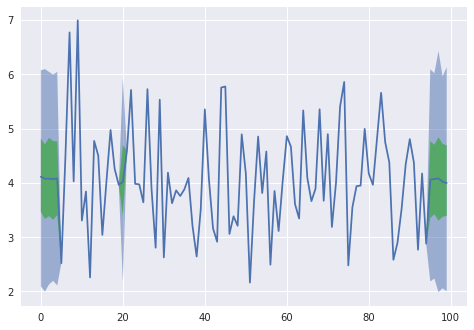

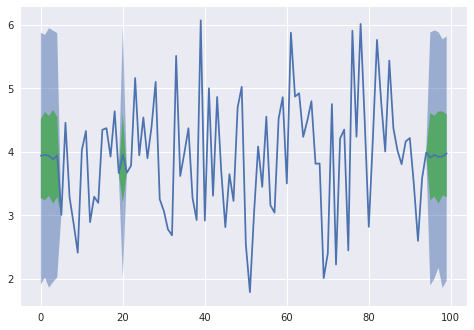

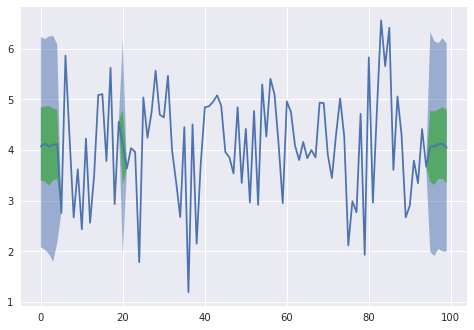

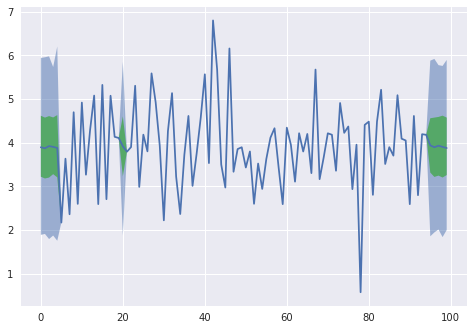

In [4]:
### Simply noise
n = 20
t = 100
sigma = 1
mu = 4

Y = (randn(t,n)*sigma)+mu

Y[:5] = nan #Some data is missing. We can model it!
Y[20] = nan
Y[-5:] = nan

model = TimeSeriesModel(Y=Y)
start_time = time()
max_depth = 15
model.sampling(n_jobs=n_jobs, iter=n_iterations, control={'max_treedepth':max_depth})
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(mu, 'mu'), (sigma, 'sigma')]
test_model_fit(model.fit, parameter_pairs, max_depth=max_depth)

print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Show priors and how they update to posteriors

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


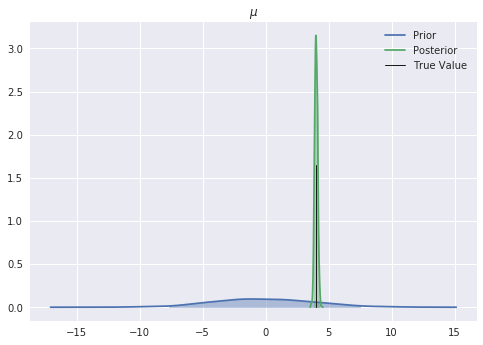

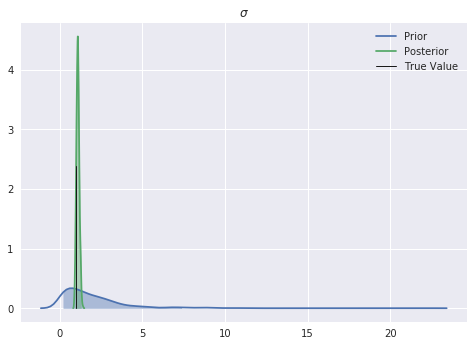

In [5]:
### Show priors and how they update to posteriors
model_priors = TimeSeriesModel(Y=Y, return_priors=True)
start_time = time()
model_priors.sampling(n_jobs=n_jobs, iter=n_iterations)
finish_time = time()

plot_distribution(model_priors.fit['mu'][:,0,0], label='Prior')
plot_distribution(model.fit['mu'][:,0,0], label='Posterior')
plot((mu,mu), (0,ylim()[1]*.5), 'k', label='True Value', linewidth=1)
legend()
title(r"$\mu$")

figure()
plot_distribution(model_priors.fit['sigma'][:,0,0], label='Prior')
plot_distribution(model.fit['sigma'][:,0,0], label='Posterior')
plot((sigma,sigma), (0,ylim()[1]*.5), 'k', label='True Value', linewidth=1)
xlim(xmin=0)
legend()
title(r"$\sigma$")

Add an autoregressive component
---
(An AR(1) model)

$\epsilon_t \sim normal(0, \sigma)$

$Y_t \sim \mu + \epsilon_t + \phi_1 Y_{t-1}$

Priors:
- $\mu \sim normal(0,4)$
- $\sigma \sim cauchy(0,4)$
- $\phi \sim normal(0,4)$

Fitting took 0.50 minutes
mu
"100% of values recovered"
"Maximum Rhat of 1.01"
sigma
"95% of values recovered"
"Maximum Rhat of 1.00"
phi
"100% of values recovered"
"Maximum Rhat of 1.01"
"0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)"
"Chain 0: E-BFMI = 1.186785547922345"
"Chain 1: E-BFMI = 0.9096270134954669"
"Chain 2: E-BFMI = 0.929062525353224"
"Chain 3: E-BFMI = 1.153662630338451"
"No divergences"
Inference for Stan model: anon_model_287fe33c577d8fab0f9d0d0c2ba2fd8e.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0,0]             3.55    0.02   0.67    2.3   3.08   3.54   3.99   4.92    852    1.0
mu[1,0]             3.29    0.02   0.59   2.09   2.89   3.31   3.67   4.45    801    1.0
mu[2,0]             3.97    0.03    0.7   2.54   3.52   3.98   4.42   5.33    729    1.0
mu[3,0]             3.13    0.0

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


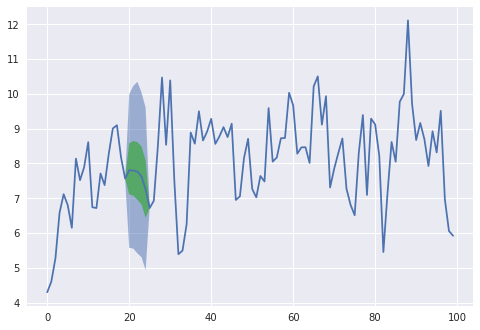

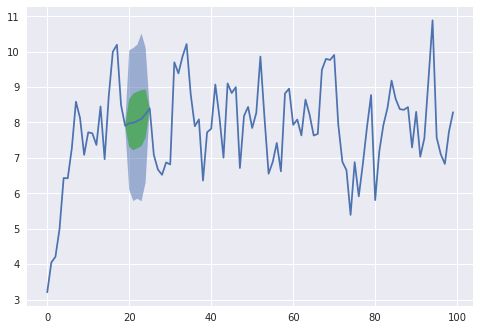

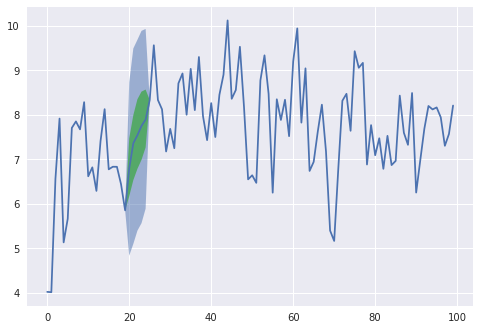

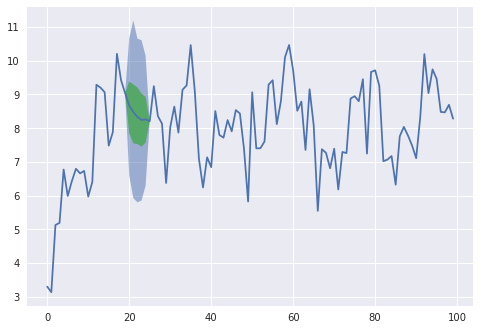

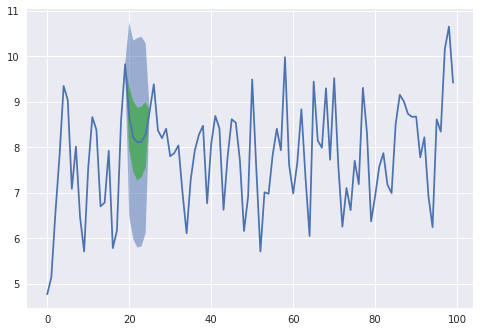

In [5]:
phi = array([.5])
p = len(phi)

Y = (randn(t,n)*sigma)+mu
for i in range(1+p,t):
    Y[i] += dot(phi,Y[i-p:i])

Y[20:25] = nan

model = TimeSeriesModel(Y=Y, p=p)
start_time = time()
model.sampling(n_jobs=n_jobs, iter=n_iterations)
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(mu, 'mu'), (sigma, 'sigma'), (phi, 'phi')]
test_model_fit(model.fit, parameter_pairs)

print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Add a second-order autoregressive component
---
(An AR(2) model)

$\epsilon_t \sim normal(0, \sigma)$

$Y_t \sim \mu + \epsilon_t + \phi_1 Y_{t-1} + \phi_2 Y_{t-2}$

Priors:
- $\mu \sim normal(0,4)$
- $\sigma \sim cauchy(0,4)$
- $\phi \sim normal(0,4)$

Fitting took 0.64 minutes
mu
"100% of values recovered"
"Maximum Rhat of 1.00"
sigma
"100% of values recovered"
"Maximum Rhat of 1.00"
phi
"92% of values recovered"
"Maximum Rhat of 1.00"
"0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)"
"Chain 0: E-BFMI = 0.9159949172527658"
"Chain 1: E-BFMI = 1.0012261514628724"
"Chain 2: E-BFMI = 0.8381806441656289"
"Chain 3: E-BFMI = 0.9656804195815835"
"No divergences"
Inference for Stan model: anon_model_287fe33c577d8fab0f9d0d0c2ba2fd8e.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0,0]             4.17    0.01   0.34   3.48   3.94   4.17   4.42   4.86   1000    1.0
mu[1,0]              3.8    0.01    0.4   3.01   3.52   3.82   4.05   4.64   1000    1.0
mu[2,0]             3.52    0.01   0.42    2.7   3.24   3.51    3.8   4.37   1000    1.0
mu[3,0]             3.72    

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


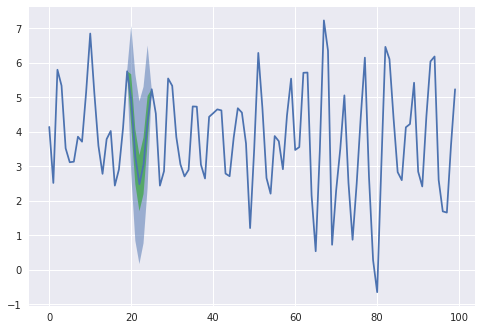

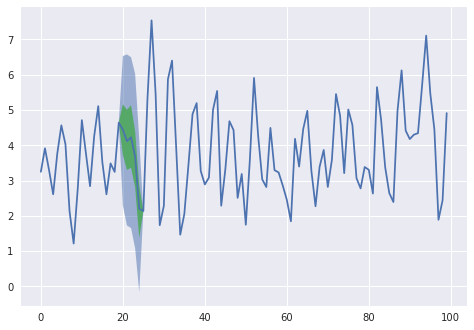

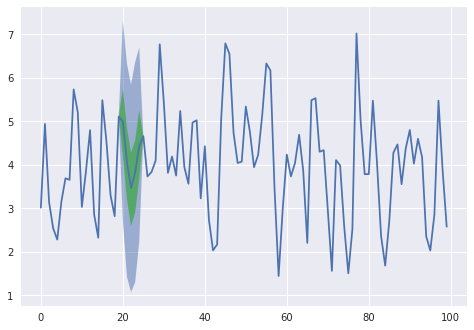

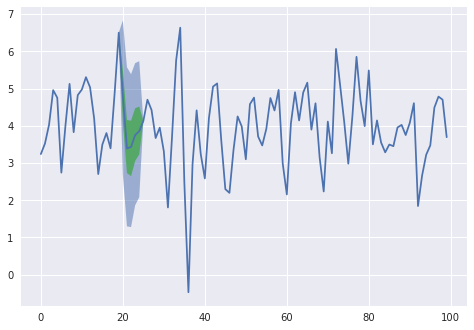

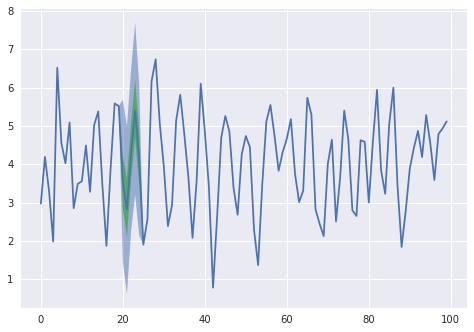

In [6]:
phi = array([.5, -.5])
p = len(phi)

Y = (randn(t,n)*sigma)+mu
for i in range(1+p,t):
    Y[i] += dot(phi[::-1],Y[i-p:i])

Y[20:25] = nan

model = TimeSeriesModel(Y=Y, p=p)
start_time = time()
model.sampling(n_jobs=n_jobs, iter=n_iterations)
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(mu, 'mu'), (sigma, 'sigma'), (phi, 'phi')]
test_model_fit(model.fit, parameter_pairs)

print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Normally distributed shocks, with a moving average component
---
(An MA(1) model)

$\epsilon_t \sim normal(0, \sigma)$

$Y_t \sim \mu + \epsilon_t + \theta \epsilon_{t-1}$

Priors:
- $\mu \sim normal(0,4)$
- $\sigma \sim cauchy(0,4)$
- $\theta \sim normal(0,4)$

Fitting took 0.43 minutes
mu
"95% of values recovered"
"Maximum Rhat of 1.00"
sigma
"95% of values recovered"
"Maximum Rhat of 1.00"
theta
"95% of values recovered"
"Maximum Rhat of 1.00"
"0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)"
"Chain 0: E-BFMI = 1.1006295746782115"
"Chain 1: E-BFMI = 0.9251717932834057"
"Chain 2: E-BFMI = 1.0960702875354336"
"Chain 3: E-BFMI = 0.9501378936986182"
"No divergences"
Inference for Stan model: anon_model_287fe33c577d8fab0f9d0d0c2ba2fd8e.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0,0]             4.11  2.9e-3   0.09   3.93   4.05   4.11   4.18    4.3   1000    1.0
mu[1,0]             4.15  3.7e-3   0.12   3.89   4.08   4.15   4.22   4.39   1000    1.0
mu[2,0]             4.25  3.3e-3   0.11   4.05   4.18   4.25   4.32   4.45   1000    1.0
mu[3,0]             3.97  2.

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


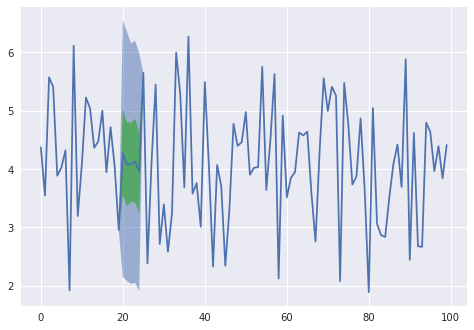

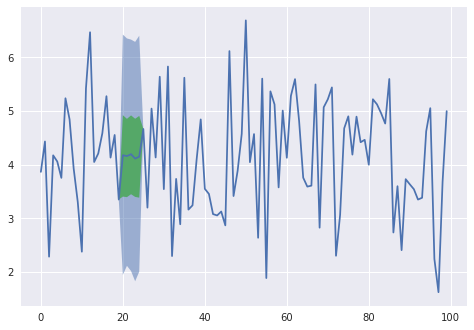

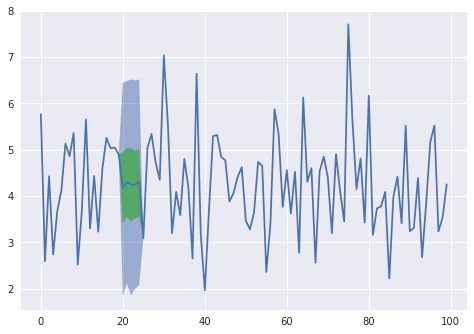

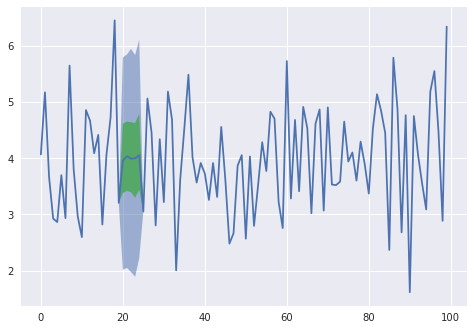

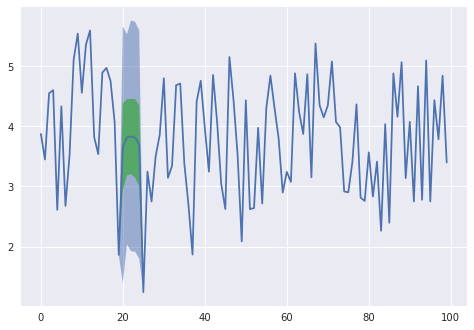

In [22]:
theta = array([.1])
q = len(theta)

errs = (randn(t,n)*sigma)
Y = mu+errs
for i in range(1+q,t):
    Y[i] += dot(theta[::-1],errs[i-q:i])

Y[20:25] = nan


model = TimeSeriesModel(Y=Y, q=q)
start_time = time()
model.sampling(n_jobs=n_jobs, iter=n_iterations)
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(mu, 'mu'), (sigma, 'sigma'), (theta, 'theta')]
test_model_fit(model.fit, parameter_pairs)

print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Add a second-order moving average component
---
(An MA(2) model)

$\epsilon_t \sim normal(0, \sigma)$

$Y_t \sim \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2}$

Priors:
- $\mu \sim normal(0,4)$
- $\sigma \sim cauchy(0,4)$
- $\theta \sim normal(0,4)$

In [ ]:
theta = array([.7, .1])
q = len(theta)

errs = (randn(t,n)*sigma)
Y = mu+errs
for i in range(1+q,t):
    Y[i] += dot(theta[::-1],errs[i-q:i])

# Y[20:25] = nan


model = TimeSeriesModel(Y=Y, q=q)
start_time = time()
max_depth = 15
model.sampling(n_jobs=n_jobs, iter=4*n_iterations, control={'max_treedepth':max_depth})
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(mu, 'mu'), (sigma, 'sigma'), (theta, 'theta')]
test_model_fit(model.fit, parameter_pairs, max_depth=max_depth)

print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Both autoregressive and moving average components
----
(An ARMA(2,2) model)

$\epsilon_t \sim normal(0, \sigma)$

$Y_t \sim \mu + \epsilon_t + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2}$

Priors:
- $\mu \sim normal(0,4)$
- $\sigma \sim cauchy(0,4)$
- $\phi \sim normal(0,4)$
- $\theta \sim normal(0,4)$

In [ ]:
phi = array([.8, -.2])
p = len(phi)

theta = array([.4,.1])
q = len(theta)

errs = (randn(t,n)*sigma)
Y = mu+errs
for i in range(1+max(p,q),t):
    Y[i] += dot(phi[::-1],Y[i-p:i]) + dot(theta,errs[i-q:i])

# Y[20:25] = nan

model = TimeSeriesModel(Y=Y, p=p, q=q)
start_time = time()
max_depth = 15
model.sampling(n_jobs=n_jobs, iter=4*n_iterations, control={'max_treedepth':max_depth})
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(mu, 'mu'), (sigma, 'sigma'), (phi, 'phi'), (theta, 'theta')]
test_model_fit(model.fit, parameter_pairs, max_depth=max_depth)

print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Changes have normally distributed shocks, with a moving average component
---
(An IMA(1,1) model)

$\epsilon_t \sim normal(0, \sigma)$

$Y_t-Y_{t-1} \sim \mu + \epsilon_t + \theta \epsilon_{t-1}$

Priors:
- $\mu \sim normal(0,4)$
- $\sigma \sim cauchy(0,4)$
- $\theta \sim normal(0,4)$

Fitting took 0.91 minutes
mu
"90% of values recovered"
"Maximum Rhat of 1.00"
sigma
"95% of values recovered"
"Maximum Rhat of 1.00"
theta
"100% of values recovered"
"Maximum Rhat of 1.00"
"0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)"
"Chain 0: E-BFMI = 0.9321898421560294"
"Chain 1: E-BFMI = 0.9936329626694371"
"Chain 2: E-BFMI = 0.9553122703688652"
"Chain 3: E-BFMI = 1.0210202931493177"
"No divergences"
Inference for Stan model: anon_model_cee94db1195c47647d7299ce07bd5f93.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0,0]             3.84  3.9e-3   0.12   3.58   3.76   3.84   3.91   4.07   1000    1.0
mu[1,0]              4.1  3.3e-3    0.1    3.9   4.02    4.1   4.17   4.29   1000    1.0
mu[2,0]             4.13  3.6e-3   0.11    3.9   4.05   4.13    4.2   4.37   1000    1.0
mu[3,0]             3.99  3

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


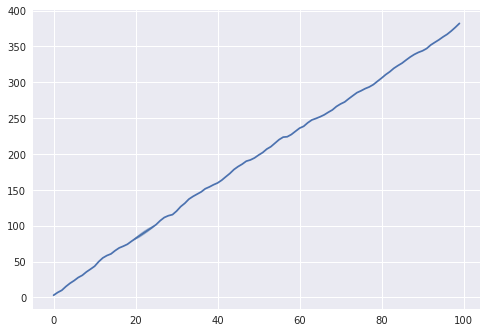

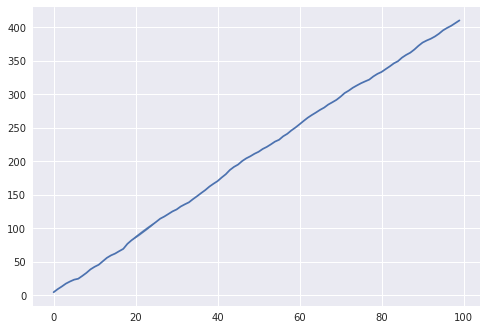

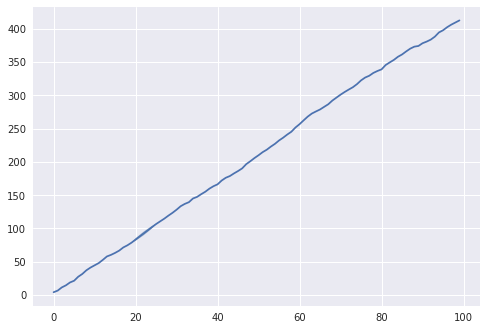

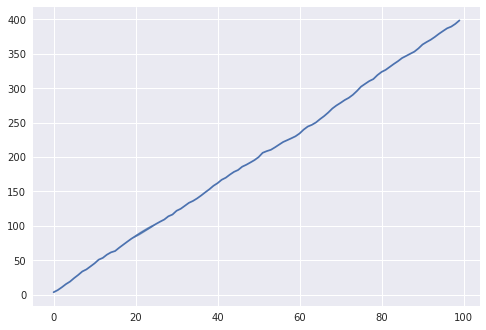

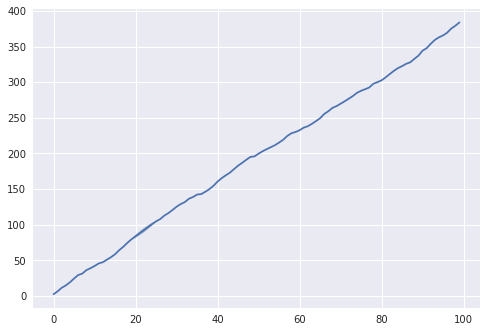

In [49]:
theta = array([.1])
q = len(theta)

errs = (randn(t,n)*sigma)
Y = mu+errs
for i in range(1+q,t):
    Y[i] += dot(theta[::-1],errs[i-q:i])
Y = cumsum(Y, axis=0)
    
Y[20:25] = nan

model = TimeSeriesModel(Y=Y, q=q, difference=[1])
start_time = time()
model.sampling(n_jobs=n_jobs, iter=n_iterations)
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(mu, 'mu'), (sigma, 'sigma'), (theta, 'theta')]
test_model_fit(model.fit, parameter_pairs)

print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Require changes are positive
---
(A monotonically-increasing IMA(1,1) model)

$\epsilon_t \sim normal(0, \sigma)$

$Y_t-Y_{t-1} \sim \mu + \epsilon_t + \theta \epsilon_{t-1}$

$Y_t-Y_{t-1} > 0$

Priors:
- $\mu \sim normal(0,4)$
- $\sigma \sim cauchy(0,4)$
- $\theta \sim normal(0,4)$

Fitting took 0.66 minutes
mu
"95% of values recovered"
"Maximum Rhat of 1.01"
sigma
"95% of values recovered"
"Maximum Rhat of 1.00"
theta
"95% of values recovered"
"Maximum Rhat of 1.00"
"0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)"
"Chain 0: E-BFMI = 0.8155594570058359"
"Chain 1: E-BFMI = 0.7270813132892628"
"Chain 2: E-BFMI = 0.9491126505039881"
"Chain 3: E-BFMI = 0.8117553033813641"
"No divergences"
Inference for Stan model: anon_model_cee94db1195c47647d7299ce07bd5f93.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0,0]             4.01  3.5e-3   0.11   3.79   3.93   4.01   4.08   4.21   1000    1.0
mu[1,0]              4.0  3.7e-3   0.12   3.77   3.93    4.0   4.08   4.24   1000    1.0
mu[2,0]             3.91  3.7e-3   0.12   3.67   3.83   3.91   3.99   4.13   1000    1.0
mu[3,0]             3.97  3.

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


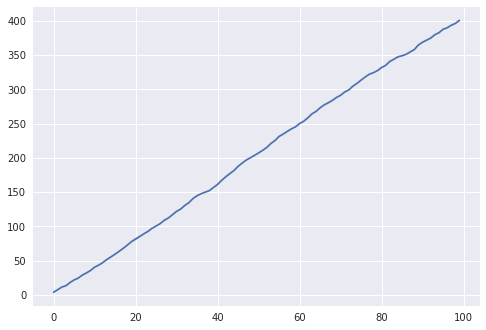

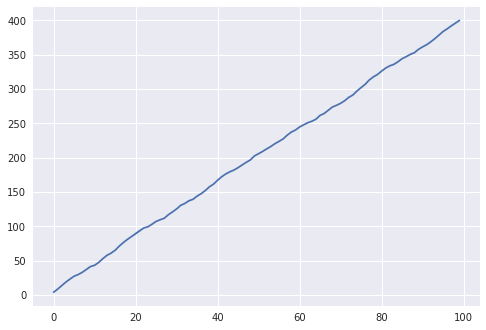

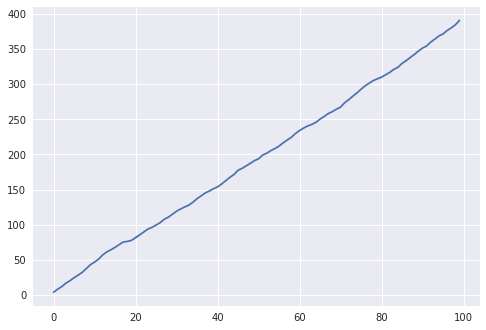

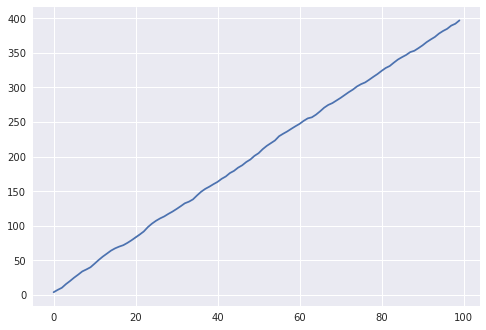

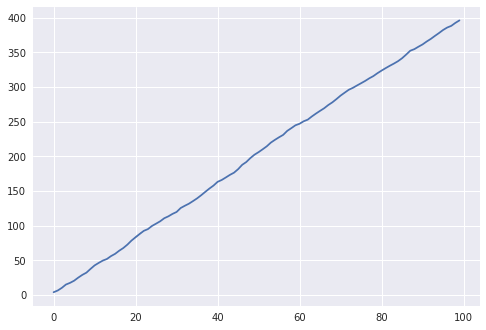

In [88]:
theta = array([.1])
q = len(theta)

from scipy.stats import truncnorm
Y = mu*ones((t,n))
errs = zeros((t,n))
for n_i in range(n):
    for t_i in range(1,q):
        expected_level = mu+Y[t_i-1,n_i]
        Y[t_i,n_i] = truncnorm(-Y[t_i-1,n_i], inf, expected_level, sigma).rvs()
        errs[t_i,n_i] = Y[t_i,n_i] - expected_level
    for t_i in range(q,t):
        expected_level = mu+dot(theta[::-1],errs[t_i-q:t_i,n_i])+Y[t_i-1,n_i]
        Y[t_i,n_i] = truncnorm(-Y[t_i-1,n_i], inf, expected_level, sigma).rvs()
        errs[t_i,n_i] = Y[t_i,n_i] - expected_level
        
Y[20:22] = nan

model = TimeSeriesModel(Y=Y, q=q, difference=[1], monotonic=[1])
start_time = time()
model.sampling(n_jobs=n_jobs, iter=n_iterations)
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(mu, 'mu'), (sigma, 'sigma'), (theta, 'theta')]
test_model_fit(model.fit, parameter_pairs)

print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Make shocks t-distributed
---
(A IMA(1,1) model, but with t-distributed shocks)

$\epsilon_t \sim t(\nu, 0, \sigma)$

$Y_t-Y_{t-1} \sim \mu + \epsilon_t + \theta \epsilon_{t-1}$

Priors:
- $\mu \sim normal(0,4)$
- $\sigma \sim cauchy(0,4)$
- $\theta \sim normal(0,4)$
- $\nu \sim caucy(0,4)$

Fitting took 9.27 minutes
nu
"90% of values recovered"
"Maximum Rhat of 1.03"
mu
"95% of values recovered"
"Maximum Rhat of 1.00"
sigma
"90% of values recovered"
"Maximum Rhat of 1.00"
theta
"75% of values recovered"
"Maximum Rhat of 1.01"
"0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)"
"Chain 0: E-BFMI = 0.9462736739481145"
"Chain 1: E-BFMI = 0.7755274811468734"
"Chain 2: E-BFMI = 0.8484933159640597"
"Chain 3: E-BFMI = 0.9543223731645687"
"No divergences"
Inference for Stan model: anon_model_c8e1eb0cc4d71a8e4bd94d914321090e.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0,0]              3.9  4.0e-3   0.13   3.66   3.81   3.89   3.98   4.15   1000    1.0
mu[1,0]             3.94  4.3e-3   0.14   3.68   3.84   3.94   4.03    4.2   1000    1.0
mu[2,0]              3.8  3.8e-3   0.12   3.56   3.72   3.81   3.

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


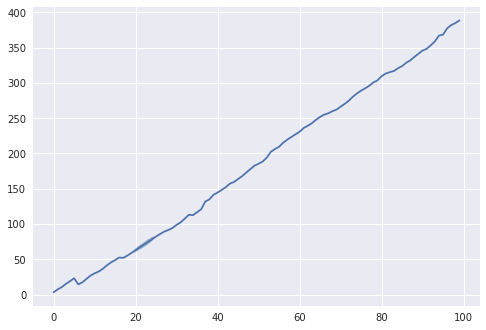

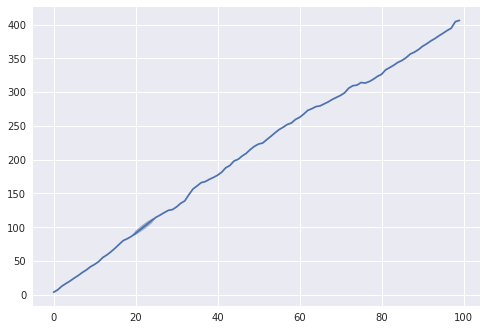

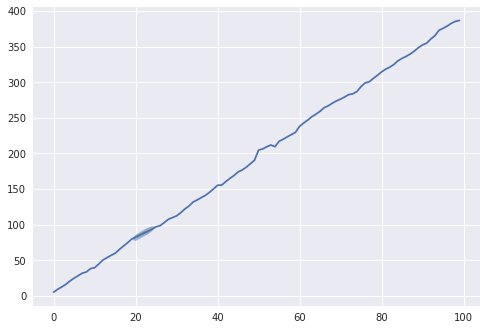

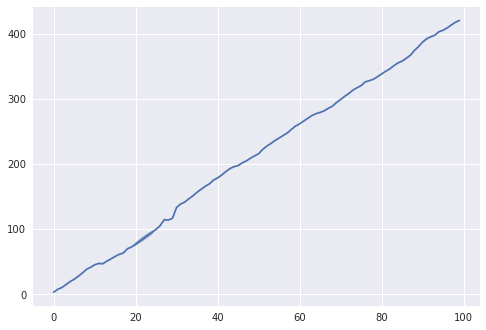

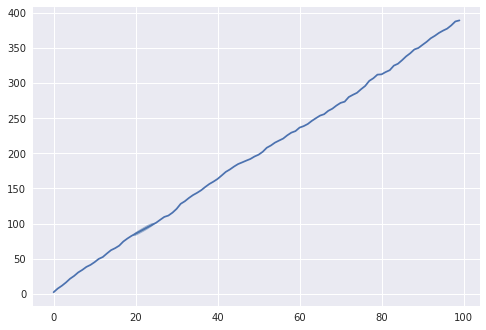

In [102]:
nu = 3

theta = array([.1])
q = len(theta)

errs = (standard_t(nu, (t,n))*sigma) 
Y = mu+errs
for i in range(1+q,t):
    Y[i] += dot(theta[::-1],errs[i-q:i])
Y = cumsum(Y, axis=0)
    
Y[20:25] = nan


model = TimeSeriesModel(Y=Y, q=q, difference=[1], use_student=True)
start_time = time()
model.sampling(n_jobs=n_jobs, iter=n_iterations)
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(nu, 'nu'), (mu, 'mu'), (sigma, 'sigma'), (theta, 'theta')]
test_model_fit(model.fit, parameter_pairs)

print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Combine inference of time series' parameters by partially pooling
---
(An MA(1) model, with partial pooling of the estimation of $\mu$, $\sigma$ and $\theta$)

$Y_{i,t} \sim \mu_i + \epsilon_t + \theta_i \epsilon_{t-1}$

$\epsilon_t \sim \text{normal}(0, \sigma_i)$

$[\mu_i, \sigma_i, \theta_i] \sim [\hat{\mu}, \hat{\sigma}, \hat{\theta}] + \text{multinormal}(0,\text{diag}(\tau)*\Omega*\text{diag}(\tau))$


Priors:
- $\hat{\mu} \sim normal(0,4)$
- $\hat{\sigma} \sim cauchy(0,4)$
- $\hat{\theta} \sim normal(0,4)$
- $\tau \sim cauchy(0,1)$ (How much each parameter varies across the time series)
- $\Omega \sim LKJ(1)$ (How the parameters correlate with each other across the time series)

Fitting took 2.17 minutes
mu
"100% of values recovered"
"Maximum Rhat of 1.00"
sigma
"100% of values recovered"
"Maximum Rhat of 1.01"
theta
"100% of values recovered"
"Maximum Rhat of 1.00"
"0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)"
"Chain 0: E-BFMI = 1.1203897211285199"
"Chain 1: E-BFMI = 0.9740688442715519"
"Chain 2: E-BFMI = 0.7720002899486516"
"Chain 3: E-BFMI = 1.1534962387319205"
"No divergences"
Inference for Stan model: anon_model_c8e1eb0cc4d71a8e4bd94d914321090e.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L_Omega[0,0]         1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   1000    nan
L_Omega[1,0]        0.29  6.4e-3    0.2  -0.14   0.16   0.31   0.44   0.65   1000    1.0
L_Omega[2,0]        -0.1  6.8e-3   0.22  -0.49  -0.26   -0.1   0.04   0.34   1000    1.0
L_Omega[0,1]         0.0 

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


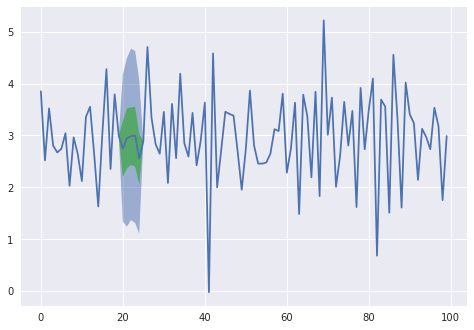

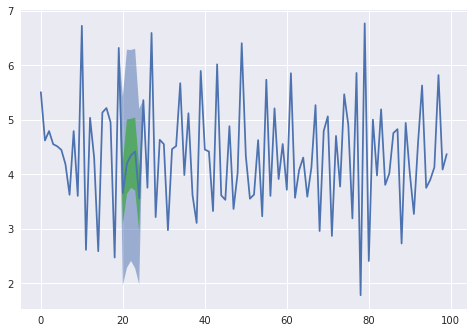

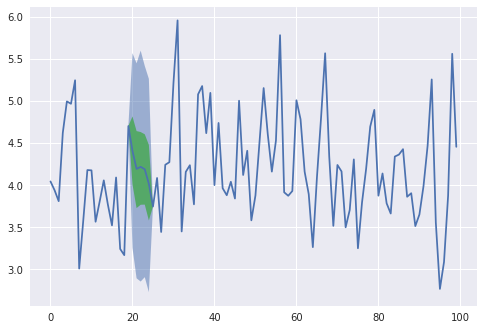

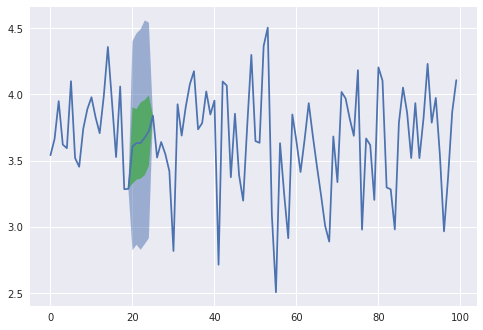

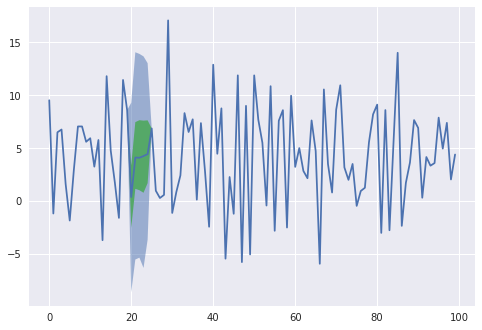

In [129]:
mu_hat = 4
sigma_hat = 1
theta_hat = .1

Omega = matrix([[1,.5,0,],
               [.5,1,0,],
               [0,0,1,]])
tau = array([1,1,1])
cov = diag(tau)*Omega*diag(tau)

from scipy.special import logit, expit

parameters = multivariate_normal(array([mu_hat, 
                                       log(sigma_hat), 
                                       logit((theta_hat+1)/2)]),
                                        cov=cov,
                                        size=n)
mu = parameters[:,0]
sigma = exp(parameters[:,1])
theta = expit(parameters[:,2])*2-1
q = 1
Y = zeros((t,n))
for n_ind in arange(n):    
    errs = randn(t)*sigma[n_ind]
    Y[:,n_ind] = mu[n_ind]+errs
    for i in range(1+q,t):
        Y[i,n_ind] += (theta[n_ind]*errs[i-q:i])

    
Y[20:25] = nan


model = TimeSeriesModel(Y=Y, q=q, use_partial_pooling=True)
start_time = time()
model.sampling(n_jobs=n_jobs, iter=n_iterations)
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(mu, 'mu'), (sigma, 'sigma'), (theta, 'theta'), (tau, 'tau')]
test_model_fit(model.fit, parameter_pairs)

print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Time series is multi-dimensional, and the different dimensions can influence each other
---
(A VAR model, with a MA(1) component)


$\vec{Y}_{t} = [Y_{1,t}, Y_{2,t}, Y_{3,t}...Y_{D,t}]$ 

$\vec{Y}_{t} \sim \vec{\mu} + \vec{\epsilon} + \vec{\theta} \vec{\epsilon}_{t-1} + \mathbf{P}\vec{Y}_{t-1}$

$\vec{\epsilon}_t \sim \text{normal}(0, \vec{\sigma})$


where $\mathbf{P}$ is a $D x D$ matrix


Priors (for each element in the vector or matrix):
- $\vec{\mu} \sim normal(0,4)$
- $\vec{\sigma} \sim cauchy(0,4)$
- $\mathbf{P} \sim normal(0,4)$
- $\vec{\theta} \sim normal(0,4)$

In [31]:
D = 3

mu = rand(D)
sigma = rand(D)

p = 1
phi = .1*rand(p,D,D)

theta = array([.2])
q = len(theta)

Y = zeros((n,t,D))
errs = (randn(n,t,D)*sigma)
for n_i in range(n):
    for t_i in range(max(q,p),t):
        Y[n_i,t_i] += mu+dot(theta[::-1],errs[n_i,t_i-q:t_i])+errs[n_i,t_i]
        for p_i in range(p):
            Y[n_i,t_i] +=  dot(phi[p_i],Y[n_i,t_i-p_i])

# Y[20:25] = nan

model = TimeSeriesModel(Y=Y, p=p, q=q)
start_time = time()
model.sampling(n_jobs=n_jobs, iter=2000)#n_iterations)
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(mu, 'mu'), (sigma, 'sigma'), (phi, 'phi'), (theta, 'theta')]
test_model_fit(model.fit, parameter_pairs)

print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Fitting took 20.07 minutes
mu
"100% of values recovered"
"Maximum Rhat of 1.03"
sigma
"80% of values recovered"
"Maximum Rhat of 1.01"
phi
"100% of values recovered"
"Maximum Rhat of 1.03"
theta
"100% of values recovered"
"Maximum Rhat of 1.03"
"0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)"
"Chain 0: E-BFMI = 1.0505956884964764"
"Chain 1: E-BFMI = 0.9830539604057824"
"Chain 2: E-BFMI = 1.0010505485571584"
"Chain 3: E-BFMI = 0.987683180595681"
"No divergences"
Inference for Stan model: anon_model_c8e1eb0cc4d71a8e4bd94d914321090e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0,0]         0.32  3.3e-3   0.19  -0.02   0.19   0.31   0.44   0.72   3140    1.0
mu[1,0]         0.49  4.1e-3    0.2   0.11   0.35   0.48   0.61   0.87   2228    1.0
mu[2,0]         0.69  6.5e-3   0.28   0.22   0.49   0.66   0.87   1.28

ValueError: No parameter Y_latent